# *$Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù*



---


## #import libraries

In [ ]:
%cd /content/drive/MyDrive/
from math import sqrt
from itertools import product
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import random
import time
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

#utils folderÏóê ÏûàÎäî data agumentation.pyÏóêÏÑú import 
from pytorch_advanced.objectdetection.utils.data_augumentation import *
from pytorch_advanced.objectdetection.utils.match import *

rootpath = './pytorch_advanced/objectdetection/data/cctv_data/'

voc_classes = ['adult','child']

# SSD 300 ÏÑ§Ï†ï

ssd_cfg = {
    'num_classes' : 2,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4], # Ï∂úÎ†•Ìï† DBox ÌôîÎ©¥ÎπÑ Ï¢ÖÎ•ò
    'feature_maps' : [38, 19, 10, 5, 3, 1], # Í∞Å sourceÏùò ÌôîÏÉÅ ÌÅ¨Í∏∞
    'steps' : [8, 16, 32, 64, 100, 300], # DBox ÌÅ¨Í∏∞ Í≤∞Ï†ï
    'min_sizes' : [30, 60, 111, 162, 213, 264], # DBox ÌÅ¨Í∏∞ Í≤∞Ï†ï
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox ÌÅ¨Í∏∞ Í≤∞Ï†ï
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]],
}

/content/drive/MyDrive


## #Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏûëÏÑ±

In [ ]:
# ÌïôÏäµ Î∞è Í≤ÄÏ¶ùÏö© ÌôîÏÉÅ Îç∞Ïù¥ÌÑ∞, Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Ïùò ÌååÏùº Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏ ÏûëÏÑ±

def make_datapath_list(rootpath):
    """
    Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°úÎ•º Ï†ÄÏû•Ìïú Î¶¨Ïä§Ìä∏ ÏûëÏÑ±
    Parameters
    ----------
    rootpath : str
        Îç∞Ïù¥ÌÑ∞ Ìè¥ÎçîÏùò Í≤ΩÎ°ú
    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú Ï†ÄÏû• Î¶¨Ïä§Ìä∏
    """

    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïùò ÌôîÏÉÅÌååÏùºÍ≥º Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò ÌååÏùºÏùò Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏ ÏûëÏÑ±
    train_img_list = glob(rootpath + 'Training/img/*.jpg')
    train_anno_list = glob(rootpath + 'Training/label/*.txt')

    # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò ÌôîÏÉÅ ÌååÏùºÍ≥º Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò ÌååÏùºÏùò Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏ ÏûëÏÑ±
    val_img_list = glob(rootpath + 'Validation/img/*.jpg')
    val_anno_list = glob(rootpath + 'Validation/label/*.txt')



    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [ ]:
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# ÎèôÏûë ÌôïÏù∏
print(len(train_img_list))
print(len(train_anno_list))
print(len(val_img_list))
print(len(val_anno_list))

933
933
193
193


## Îç∞Ïù¥ÌÑ∞ imageÏóê ÏûàÎäî Í∞ùÏ≤¥ÏôÄ bbox Ï¢åÌëú mapping ÏßÑÌñâ

ÏÇ¨Ïã§ SSD Î™®Îç∏ÏùÑÏùÑ ÎèåÎ¶¥ÎïåÎäîÎäî Î™áÍ∞úÏùòÏùò mappingÎßåÎßå Î≥¥Í≥†Í≥† ÏûòÏûò Ïû°ÌòîÎã§Í≥†Í≥† ÌåêÎã®ÌïòÏó¨Ïó¨ modelÏóêÏóê ÎÑ£ÏóàÎäîÎç∞Îç∞,

yolo modelÏùÑ ÎèåÎ¶¨Í∏∞ ÏúÑÌï¥ yolo Ï¢åÌëúÎ°ú Î∞îÍøî mappingÌïòÎçò ÎèÑÏ§ë Ï†ÑÏ≤¥Ï†ÅÏù∏ mappingÏÜçÏóê Î™áÎ™áÍ∞úÍ∞Ä Ï†úÎåÄÎ°ú boundingÎêòÏßÄ ÏïäÏïÑÏûàÏùåÏùÑ ÌåêÎã®ÌïòÏòÄÎã§.

ÏΩîÎìúÏùò Î¨∏Ï†úÏù∏Í∞Ä ÏÉùÍ∞ÅÍ∞ÅÌï¥Î¥§ÎäîÎç∞, Í∑∏Î†áÎã§Í∏∞ÏóêÎäî Îã§Î•∏ ÎßéÏùÄ imageÎäî Ïûò boundingÎêòÏñ¥ ÏûàÏñ¥ labelingÍ≥ºÏ†ïÏóêÏÑúÏùò Î¨∏Ï†úÎèÑ ÏùòÏã¨ÌïòÏßÄ ÏïäÏùÑ Ïàò ÏóÜÎã§.

Í∑∏Î¶¨ÌïòÏó¨ Í≤∞Î°† ÎÇ¥Î¶∞Í≤ÉÏùÄ boundingÎêòÏßÄ ÏïäÏùÄ Î™®Îì† imageÏôÄ label ÌååÏùºÏùÑ ÏÇ≠Ï†úÌïòÍ∏∞Î°ú Í≤∞Ï†ïÌñàÎã§.

In [ ]:
#Îç∞Ïù¥ÌÑ∞ imageÏôÄ bbox Ï¢åÌëú mapping ÌôïÏù∏

import matplotlib.patches as patches
import matplotlib.image as mpimg
 
images_names = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/*.jpg')
labels_names = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/*.txt')
images_names.sort()
labels_names.sort()

print(len(images_names),len(labels_names)) #Îëê Î¶¨Ïä§Ìä∏ÎÇ¥ Í∞íÎì§Ïùò Í∞úÏàòÍ∞Ä Í∞ôÏùÄÏßÄ ÌôïÏù∏

for i in range(len(images_names)):
    print(images_names[i])
    img = plt.imread(images_names[i])
    label = open(labels_names[i])
    bboxs = label.read().splitlines()
    trans_xml_bboxs = []
    for obj in bboxs:
        trans_xml_bboxs.append(obj.split())


    # Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
    plt.imshow(img)

    # bounindg box Í∑∏Î¶¨Í∏∞
    for trans_xml_bbox in trans_xml_bboxs:
        print(trans_xml_bbox)

        cat, xmin, ymin, xmax, ymax = trans_xml_bbox
        rect = patches.Rectangle((float(xmin), float(ymin)), float(xmax)-float(xmin), float(ymax)-float(ymin), linewidth=2, edgecolor='red', fill=False)
        ax = plt.gca()
        ax.add_patch(rect)

    plt.xticks([]); plt.yticks([])
    plt.show()
    
#OUT PUT ÏùÄ ÏóÖÎ°úÎìú Ï†ÄÏû•Ïö©ÎüâÏúºÎ°ú Ïù∏Ìï¥ Î∂ÄÎìùÏù¥ÌïòÍ≤å ÏÉùÎûµ...

In [ ]:
# ÏßÅÏ†ë Î¥§ÏùÑ Îïå Í∞ùÏ≤¥ÏôÄ label Î∞ïÏä§Í∞Ä ÎßûÏßÄÏßÄ ÏïäÏùÄ ÌååÏùºÎì§ Î¶¨Ïä§Ìä∏

delete_list = ['/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_100.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_110.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_120.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_130.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_140.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_170.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_180.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_190.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_200.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_210.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_220.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_230.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_240.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_250.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_290.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_300.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_310.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_320.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_330.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_340.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_350.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_360.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_460.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_470.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_480.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_490.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_500.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_510.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_520.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_70.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_80.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-07_16-09-00_90.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_0.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_10.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_100.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_110.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_130.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_140.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_150.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_160.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_170.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_180.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_20.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_200.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_210.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_220.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_230.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_240.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_250.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_260.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_30.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_370.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_380.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_390.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_40.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_400.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_410.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_420.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_430.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_450.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_460.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_470.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_480.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_50.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_60.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_70.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_80.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-00-00_90.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_0.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_100.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_110.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_120.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_130.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_140.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_150.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_160.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_170.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_180.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_190.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_200.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_210.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_220.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_230.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_240.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_250.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_260.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_270.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_280.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_290.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_300.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_310.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_320.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_330.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_340.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_370.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_380.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_390.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_400.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_410.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_420.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_430.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_440.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_450.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_460.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_470.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_480.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_50.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_500.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_510.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_520.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_530.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_60.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_70.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_80.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-12-00_90.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_0.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_100.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_110.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_120.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_130.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_140.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_150.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_160.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_170.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_180.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_190.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_20.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_200.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_210.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_220.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_230.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_240.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_250.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_260.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_270.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_280.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_290.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_30.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_300.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_310.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_330.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_340.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_350.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_360.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_370.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_380.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_390.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_40.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_400.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_410.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_420.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_430.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_440.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_450.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_460.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_470.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_480.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_50.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_60.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_70.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_80.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_08-15-00_90.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_16-33-00_0.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-08_16-45-00_450.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_0.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_10.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_100.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_110.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_120.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_130.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_140.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_150.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_160.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_170.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_180.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_190.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_20.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_200.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_210.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_220.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_230.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_240.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_250.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_260.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_270.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_30.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_300.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_310.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_320.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_330.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_340.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_350.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_360.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_390.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_40.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_400.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_410.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_420.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_430.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_440.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_50.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_510.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_520.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_530.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_60.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_70.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_80.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-48-00_90.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_100.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_110.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_120.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_130.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_140.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_150.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_160.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_170.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_180.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_190.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_200.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_210.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_220.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_230.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_250.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_260.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_270.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_280.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_290.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_300.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_330.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_340.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_350.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_360.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_370.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_380.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_390.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_400.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_410.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_420.jpg',
              '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-09_07-51-00_90.jpg',
              ]

In [ ]:
print(len(delete_list))
print(933 - len(delete_list))
# ÏúÑ delete list ÌååÏùºÎì§ÏùÑ ÏßÄÏö∞Î©¥ 694Í∞úÎßå ÎÇ®ÏïÑÏïºÌïúÎã§Îäî Í≤ÉÏùÑ Ïïå Ïàò ÏûàÎã§.

239
694


In [ ]:
# ÏúÑ Î¶¨Ïä§Ìä∏Ïóê ÏûàÎäî ÌååÏùºÎì§ Ï†úÍ±∞

import os

imgpath = "/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img"
labelpath = '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label'

img_list = os.listdir(imgpath)
label_list = os.listdir(labelpath)
img_list = sorted(img_list)
label_list = sorted(label_list)

print(len(img_list))
print(len(label_list))


# #ÏïÑÎûòÎûò ÏΩîÎìúÎ•º Ïã§ÌñâÌïòÍ≥† ÏúÑ printÍπåÏßÄÎßå Îã§Ïãú ÏÇ¥ÌñâÌïòÏó¨ data folderÏóê Ï†úÍ±∞Îêú Í∞úÏàòÍ∞Ä ÎßûÎäîÏßÄ ÌôïÏù∏ÌïòÏòÄÎã§.
count = 0
a = 0
for img,label in zip(img_list,label_list):
    img_path = imgpath +'/'+ img
    label_path = labelpath +'/'+ label

    if img_path in delete_list:
        #print("yes")
        if os.path.exists(img_path):
            print(img_path,"ÏÇ≠Ï†ú")
            print(label_path,'ÏÇ≠Ï†ú')
            os.remove(img_path)
            os.remove(label_path)
            print('-')
            count+=1
            continue
    else:
        if img_path in ['./cctv_data/Validation/label_data/.ipynb_checkpoints','./cctv_data/Validation/label_data/.ipynb_checkpoints.json']:
            continue
        if label_path in ['./cctv_data/Validation/label_data/.ipynb_checkpoints','./cctv_data/Validation/label_data/.ipynb_checkpoints.json']:
            continue
        elif os.path.exists(img_path):
            print(img_path,'Î≥¥Ï°¥')
            print(label_path,'Î≥¥Ï°¥')
            print('-')
            a += 1
print(count)
print(a)

933
933
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-02_07-54-00_10.jpg Î≥¥Ï°¥
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/2021-09-02_07-54-00_10.txt Î≥¥Ï°¥
-
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-02_07-54-00_120.jpg Î≥¥Ï°¥
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/2021-09-02_07-54-00_120.txt Î≥¥Ï°¥
-
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-02_07-54-00_130.jpg Î≥¥Ï°¥
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/2021-09-02_07-54-00_130.txt Î≥¥Ï°¥
-
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/2021-09-02_07-54-00_140.jpg Î≥¥Ï°¥
/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/2021-09-02_07-54-00_140.txt Î≥¥Ï°¥
-
/content/drive/MyDrive/pyt

### Ïù¥Î†áÍ≤å Ìï¥ÏÑú Í≤∞Î°† Train dataÎäî 694Í∞úÎ°ú ÏÑ∏ÌåÖÎêêÎã§.

In [ ]:
# XML ÌòïÏãùÏùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Î¶¨Ïä§Ìä∏ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌïòÎäî ÌÅ¥ÎûòÏä§


class Anno_xml2list(object):
    """
    Ìïú ÌôîÏÉÅÏùò XML ÌòïÏãù Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Î•º ÌôîÏÉÅ ÌÅ¨Í∏∞Î°ú Í∑úÍ≤©ÌôîÌïòÏó¨ Î¶¨Ïä§Ìä∏ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
    
    Attributes
    ----------
    classes : Î¶¨Ïä§Ìä∏
        VOCÏùò ÌÅ¥ÎûòÏä§Î™ÖÏùÑ Ï†ÄÏû•Ìïú ÌÅ¥ÎûòÏä§
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, txt_path, width, height):
        """
        Ìïú ÌôîÏÉÅÏùò XML ÌòïÏãù Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Î•º ÌôîÏÉÅ ÌÅ¨Í∏∞Î°ú Í∑úÍ≤©ÌôîÌïòÏó¨ Î¶¨Ïä§Ìä∏ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
        Parameters
        ----------
        txt_path : str
            txt ÌååÏùº Í≤ΩÎ°ú
        width : int
            ÎåÄÏÉÅ ÌôîÏÉÅ Ìè≠
        height : int
            ÎåÄÏÉÅ ÌôîÏÉÅ ÎÜíÏù¥
        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            Î¨ºÏ≤¥Ïùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•Ìïú Î¶¨Ïä§Ìä∏. ÌôîÏÉÅÏóê Ï°¥Ïû¨ÌïòÎäî Î¨ºÏ≤¥ ÏàòÎßåÌÅºÏùò ÏöîÏÜåÎ•º Í∞ÄÏßê.
        """

        # ÌôîÏÉÅ ÎÇ¥ Î™®Îì† Î¨ºÏ≤¥Ïùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Ïù¥ Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•
        ret = []

        # txt ÌååÏùº Î°úÎìú
        txt = open(txt_path,'r')
        bbox = txt.read().splitlines()

        # ÌôîÏÉÅ ÎÇ¥ Î¨ºÏ≤¥Ïùò Ïàò ÎßåÌÅº Î∞òÎ≥µ
        for obj in bbox:

          cls,xmin,ymin,xmax,ymax = obj.split()

          xmin = float(xmin) / width
          xmax = float(xmax) / width
          ymin = float(ymin) / height
          ymax = float(ymax) / height
          a = [float(xmin),float(ymin),float(xmax),float(ymax),float(cls)]
          ret.append(a)

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [ ]:
transform_anno = Anno_xml2list(voc_classes)

# ÌôîÏÉÅ Î°úÎìúÏö©ÏúºÎ°ú Opencv ÏÇ¨Ïö©
ind = 1
img_file_path = val_img_list[ind]
img = cv2.imread(img_file_path) # [ÎÜíÏù¥][Ìè≠][ÏÉâBGR]
height, width, channels = img.shape # ÌôîÏÉÅ ÌÅ¨Í∏∞ Ï∑®Îìù

# Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Î¶¨Ïä§Ìä∏Î°ú ÌëúÏãú
transform_anno(val_anno_list[ind], width, height)

array([[0.18667603, 0.38251591, 0.20442708, 0.46787037, 0.        ],
       [0.15665487, 0.36843533, 0.17276042, 0.45833333, 0.        ],
       [0.40502662, 0.25534199, 0.41446496, 0.30853535, 0.        ]])

In [ ]:
# ÏûÖÎ†• ÏòÅÏÉÅÏùò Ï†ÑÏ≤òÎ¶¨ ÌÅ¥ÎûòÏä§

class DataTransform():
    """
    ÌôîÏÉÅÍ≥º Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùò Ï†ÑÏ≤òÎ¶¨ ÌÅ¥ÎûòÏä§. ÌõàÎ†®Í≥º Ï∂îÎ°†ÏóêÏÑú Îã§Î•¥Í≤å ÏûëÎèô.
    ÌôîÏÉÅ ÌÅ¨Í∏∞Î•º 300*300ÏúºÎ°ú ÌïúÎã§.
    ÌïôÏäµ Ïãú Îç∞Ïù¥ÌÑ∞ ÌôïÏû•ÏùÑ ÏàòÌñâ.
    Attributes
    ----------
    input_size : int
        Î¶¨ÏÇ¨Ïù¥Ï¶à ÎåÄÏÉÅ ÌôîÏÉÅÏùò ÌÅ¨Í∏∞
    color_mean : (B, G, R)
        Í∞Å ÏÉâÏÉÅÏ±ÑÎÑê ÌèâÍ∑† Í∞í
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intÎ•º float32Î°ú Î≥ÄÌôò
                ToAbsoluteCoords(),  # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Ïùò Í∑úÍ≤©Ìôî Î∞òÌôò
                RandomSampleCrop(),  # ÌôîÏÉÅ ÎÇ¥ ÌäπÏ†ï Î∂ÄÎ∂Ñ Î¨¥ÏûëÏúÑ Ï∂îÏ∂ú
                ToPercentCoords(),  # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Î•º 0 ~ 1Î°ú Í∑úÍ≤©Ìôî
                Resize(input_size),  # ÌôîÏÉÅ ÌÅ¨Í∏∞Î•º input_size*input_sizeÎ°ú Î≥ÄÌòï
                SubtractMeans(color_mean)  # BGR ÏÉâÏÉÅ ÌèâÍ∑†Í∞í ÎπºÍ∏∞
            ]),
            'val': Compose([
                ConvertFromInts(),  # intÎ•º float32Î°ú Î≥ÄÌôò
                Resize(input_size),  # ÌôîÏÉÅ ÌÅ¨Í∏∞Î•º input_size * input_sizeÎ°ú Î≥ÄÌôò
                SubtractMeans(color_mean)  # BGR ÏÉâÏÉÅ ÌèâÍ∑†Í∞í ÎπºÍ∏∞
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            Ï†ÑÏ≤òÎ¶¨ Î™®Îìú ÏßÄÏ†ï
        """
        return self.data_transform[phase](img, boxes, labels)

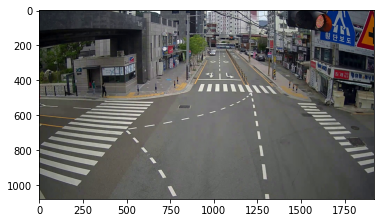

/content/drive/MyDrive/pytorch_advanced/objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


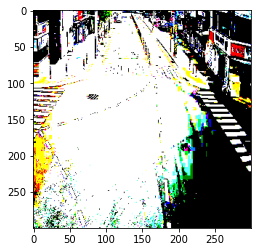

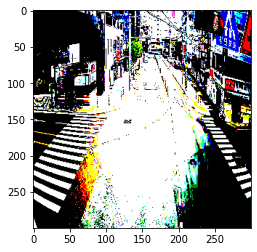

In [ ]:
# ÎèôÏûë ÌôïÏù∏

# 1. ÌôîÏÉÅ ÏùΩÍ∏∞
image_file_path = train_img_list[0]
img = cv2.imread(img_file_path) # [ÎÜíÏù¥][Ìè≠][ÏÉâBGR]
height, width, channels = img.shape # ÌôîÏÉÅ ÌÅ¨Í∏∞ Ï∑®Îìù


# 2. Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Î¶¨Ïä§Ìä∏Î°ú
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. ÏõêÎ≥∏ ÌëúÏãú
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. Ï†ÑÏ≤òÎ¶¨ ÌÅ¥ÎûòÏä§ ÏûëÏÑ±
color_mean = (90.6,92.5,92.6) # (bgr) ÏÉâÏÉÅÏùò ÌèâÍ∑†Í∞í
input_size = 300
transform = DataTransform(input_size, color_mean)

# 5. Train ÌôîÏÉÅ ÌëúÏãú
phase = 'train'
img_transformed, boxes, labels = transform(
                                    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. Val ÌôîÏÉÅ ÌëúÏãú
phase = 'val'
img_transformed, boxes, labels = transform(
                                    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# VOC2012Ïùò dataset ÏûëÏÑ±

class VOCDataset(data.Dataset):
    """
    VOC2012Ïùò Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏûëÏÑ±ÌïòÎäî ÌÅ¥ÎûòÏä§. ÌååÏù¥ÌÜ†ÏπòÏùò dataset ÌÅ¥ÎûòÏä§Î•º ÏÉÅÏÜç
    ----------
    img_list : Î¶¨Ïä§Ìä∏
        ÌôîÏÉÅ Í≤ΩÎ°úÎ•º Ï†ÄÏû•Ìïú Î¶¨Ïä§Ìä∏
    anno_list : Î¶¨Ïä§Ìä∏
        Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Í≤ΩÎ°úÎ•º Ï†ÄÏû•Ìïú Î¶¨Ïä§Ìä∏
    phase : 'train' or 'test'
        ÌïôÏäµ ÎòêÎäî ÌõàÎ†® ÏÑ§Ï†ï
    transform : object
        Ï†ÑÏ≤òÎ¶¨ ÌÅ¥ÎûòÏä§ Ïù∏Ïä§ÌÑ¥Ïä§
    transform_anno : object
        xml Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôòÌïòÎäî Ïù∏Ïä§ÌÑ¥Ïä§
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train ÎòêÎäî val ÏßÄÏ†ï
        self.transform = transform  # ÌôîÏÉÅ Î≥ÄÌòï
        self.transform_anno = transform_anno  # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Î•º xmlÏóêÏÑú Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÍ≤Ω

    def __len__(self):
        '''ÌôîÏÉÅÏùò Îß§Ïàò Î∞òÌôò'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        Ï†ÑÏ≤òÎ¶¨Ìïú ÌôîÏÉÅÏùò ÌÖêÏÑú ÌòïÏãù Îç∞Ïù¥ÌÑ∞ÏôÄ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Ï∑®Îìù
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''Ï†ÑÏ≤òÎ¶¨Ìïú ÌôîÏÉÅÏùò ÌÖêÏÑú ÌòïÏãù Îç∞Ïù¥ÌÑ∞, Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò, ÌôîÏÉÅÏùò ÎÜíÏù¥, Ìè≠ Ï∑®Îìù'''

        # 1. ÌôîÏÉÅ ÏùΩÍ∏∞
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [ÎÜíÏù¥][Ìè≠][ÏÉâBGR]
        height, width, channels = img.shape  # ÌôîÏÉÅ ÌÅ¨Í∏∞ Ï∑®Îìù

        # 2. xml ÌòïÏãùÏùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Ï†ïÎ≥¥Î•º Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. Ï†ÑÏ≤òÎ¶¨ Ïã§Ïãú
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # ÏÉâÏÉÅ Ï±ÑÎÑêÏúº „Ö£ÏàúÏÑúÍ∞Ä BGRÏù¥ÎØÄÎ°ú RGBÎ°ú ÏàúÏÑú Î≥ÄÍ≤Ω
        # (ÎÜíÏù¥, Ìè≠, ÏÉâÏÉÅ Ï±ÑÎÑê)Ïùò ÏàúÏÑúÎ•º (ÏÉâÏÉÅ Ï±ÑÎÑê, ÎÜíÏù¥, Ìè≠)ÏúºÎ°ú Î≥ÄÍ≤Ω
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxÏôÄ ÎùºÎ≤®ÏùÑ ÏÑ∏Ìä∏Î°ú Ìïú np.array ÏûëÏÑ±. Î≥ÄÏàò Ïù¥Î¶Ñ gtÎäî ground truthÏùò ÏùòÎØ∏
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [ ]:
# ÎèôÏûë ÌôïÏù∏
color_mean = (90.6,92.5,92.6) # BGR ÌèâÍ∑†Í∞í
input_size = 300 # ÌôîÏÉÅÏùò input ÏÇ¨Ïù¥Ï¶àÎ•º 300*300ÏúºÎ°ú Ìï®.

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                transform=DataTransform(input_size, color_mean),
                transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='train',
                transform=DataTransform(input_size, color_mean), 
                transform_anno=Anno_xml2list(voc_classes))

# Îç∞Ïù¥ÌÑ∞ Ï∂úÎ†• Ïòà
val_dataset.__getitem__(1)

(tensor([[[-73.7767, -74.5541, -75.7066,  ...,  91.7905,  95.2441,  17.9878],
          [-73.6000, -73.6000, -74.7167,  ...,  94.1193, 103.9078,  24.5393],
          [-72.4667, -72.2450, -72.6000,  ..., 100.4445, 106.4783,  13.1488],
          ...,
          [ -3.6000,  -0.3363,   0.4000,  ...,  -6.4833,  -4.6000,  -4.6000],
          [ -3.8141,  -1.2078,  -0.8600,  ...,  -6.4833,  -4.6000,  -4.6000],
          [ -2.0284,  -1.2119,  -2.6101,  ...,  -6.5801,  -4.6459,  -4.3553]],
 
         [[-73.6767, -73.9241, -74.6066,  ...,  93.8905,  96.8741,  19.0878],
          [-73.5000, -73.5000, -74.6167,  ...,  96.2193, 105.5378,  25.6393],
          [-72.3667, -72.1450, -72.5000,  ..., 102.5444, 108.1083,  14.2488],
          ...,
          [ -7.5000,  -4.2363,  -3.5000,  ...,  -4.3833,  -2.5000,  -2.5000],
          [ -7.7141,  -5.1078,  -4.7600,  ...,  -4.3833,  -2.5000,  -2.5000],
          [ -5.9284,  -5.1119,  -6.5101,  ...,  -4.4801,  -2.5459,  -2.2553]],
 
         [[-69.7767, -68.964

In [ ]:
def od_collate_fn(batch):
    """
    DatasetÏóêÏÑú Í∫ºÎÇ¥Îäî Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞Îäî ÌôîÏÉÅÎßàÎã§ Îã§Î•¥Îã§.
    ÌôîÏÉÅ ÎÇ¥Ïùò Î¨ºÏ≤¥ ÏàòÍ∞Ä ÎëêÍ∞úÏù¥Î©¥ (2, 5)ÏÇ¨Ïù¥Ï¶àÏù¥ÏßÄÎßå, ÏÑ∏ Í∞úÏù¥Î©¥ (3, 5) Îì±ÏúºÎ°ú Î∞îÎÄêÎã§.
    Î≥ÄÌôîÏóê ÎåÄÏùëÌïòÎäî DataLoaderÎ•º ÎßåÎìúÎäî collate_fnÏùÑ ÏûëÏÑ±ÌïúÎã§.
    collate_fnÏùÄ ÌååÏù¥ÌÜ†Ïπò Î¶¨Ïä§Ìä∏Î°ú mini batchÎ•º ÏûëÏÑ±ÌïòÎäî Ìï®ÏàòÏù¥Îîî„Öè.
    ÎØ∏Îãà Î∞∞Ïπò Î∂ÑÎüâ ÌôîÏÉÅÏù¥ ÎÇòÏó¥Îêú Î¶¨Ïä§Ìä∏ Î≥ÄÏàò batchÏóê ÎØ∏Îãà Î∞∞Ïπò Î≤àÌò∏Î•º ÏßÄÏ†ïÌïòÎäî 
    Ï∞®ÏõêÏùÑ Í∞ÄÏû• ÏïûÏóê ÌïòÎÇò Ï∂îÍ∞ÄÌïòÏó¨ Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ•º Î≥ÄÌòïÌïúÎã§.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]ÏùÄ ÌôîÏÉÅ gt
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]ÏùÄ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò gt

    # imgsÎäî ÎØ∏ÎãàÎ∞∞Ïπò ÌÅ¨Í∏∞Ïúº „Ö£Î¶¨Ïä§Ìä∏
    # Î¶¨Ïä§Ìä∏ ÏöîÏÜåÎäî torch.Size([3, 300, 300])
    # Ïù¥ Î¶¨Ïä§Ìä∏Î•º torch.Size([batch_num, 3, 300, 300])Ïùò ÌÖêÏÑúÎ°ú Î≥ÄÌôò
    imgs = torch.stack(imgs, dim=0)

    # targetsÏùÄ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùò Ï†ïÎãµÏù∏ gt Î¶¨Ïä§Ìä∏
    # Î¶¨Ïä§Ìä∏ ÌÅ¨Í∏∞ = ÎØ∏Îãà Î∞∞Ïπò ÌÅ¨Í∏∞
    # targets Î¶¨Ïä§Ìä∏Ïùò ÏöîÏÜåÎäî [n, 5] 
    # nÏùÄ ÌôîÏÉÅÎßàÎã§ Îã§Î•¥Î©∞ ÌôîÏÉÅ ÏÜç Î¨ºÏ≤¥Ïùò Ïàò
    # 5Îäî [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎçî ÏûëÏÑ±
batch_size = 4

train_dataloader = data.DataLoader(
                        train_dataset, 
                        batch_size =batch_size, shuffle=True, 
                        collate_fn=od_collate_fn)


val_dataloader = data.DataLoader(
                        val_dataset, 
                        batch_size =batch_size, shuffle=True, 
                        collate_fn=od_collate_fn)

# ÏÇ¨Ï†ÑÌòï Î≥ÄÏàòÏóê Ï†ïÎ¶¨
dataloaders_dict = {'train' : train_dataloader,
                    'val' : val_dataloader}

# ÎèôÏûë ÌôïÏù∏
batch_iterator = iter(dataloaders_dict['val']) # Î∞òÎ≥µÏûêÎ°ú Î≥ÄÌôò
images, targets = next(batch_iterator) # Ï≤´Î≤àÏß∏ ÏöîÏÜå Ï∂îÏ∂ú
print(images.size()) # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size()) # ÎØ∏Îãà Î∞∞Ïπò ÌÅ¨Í∏∞ Î¶¨Ïä§Ìä∏, Í∞Å ÏöîÏÜåÎäî [n, 5] , nÏùÄ Î¨ºÏ≤¥ Ïàò

torch.Size([4, 3, 300, 300])
4
torch.Size([1, 5])


In [ ]:
print(train_dataset.__len__())
print(val_dataset.__len__())

933
193


## Make Vgg

34Ï∏µÏóê Í±∏Ïπú vgg Î™®Îìà ÏûëÏÑ±

In [ ]:
# 34Ï∏µÏóê Í±∏Ïπú vgg Î™®ÎìàÏùÑ ÏûëÏÑ±

def make_vgg():
    layers = []
    in_channels = 3  # ÏÉâ Ï±ÑÎÑê Ïàò

    # vgg Î™®ÎìàÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî Ìï©ÏÑ±Í≥± Ï∏µÏù¥ÎÇò ÏµúÎåÄ ÌíÄÎßÅ Ï±ÑÎÑê Ïàò 
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilÏùÄ Í≥ÑÏÇ∞ Í≤∞Í≥º(float)ÏóêÏÑú Ï∂úÎ†• ÌÅ¨Í∏∞Ïùò ÏÜåÏàòÏ†êÏùÑ Ïò¨Î†§ Ï†ïÏàòÎ°ú ÌïòÎäî Î™®Îìú
            # defaultÎäî Í≥ÑÏÇ∞ Í≤∞Í≥º(float)ÏóêÏÑú Ï∂úÎ†• ÌÅ¨Í∏∞Ïùò ÏÜåÏàòÏ†êÏùÑ Î≤ÑÎ†§ Ï†ïÏàòÎ°ú ÌïòÎäî floor Î™®Îìú
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # ReLU Ïù∏Ïàò inplaceÎäî ReLUÏóê ÎåÄÌïú ÏûÖÎ†•ÏùÑ Î©îÎ™®Î¶¨ ÏÉÅÏóê Ïú†ÏßÄÌï† Í≤ÉÏù∏ÏßÄ, ÌòπÏùÄ
            # ÏûÖÎ†•ÏùÑ Ïû¨ÏûëÏÑ± ÌïòÏó¨ Ï∂úÎ†•ÏúºÎ°ú Î∞îÍæº ÌõÑ Î©îÎ™®Î¶¨ÏÉÅÏóê Ïú†ÏßÄÌïòÏßÄ ÏïäÏùÑ Í≤ÉÏù∏ÏßÄÎ•º ÎÇòÌÉÄÎÉÑ.
            # inplace=True ÏûÖÎ†• Ïãú Î©îÎ™®Î¶¨ÏÉÅÏóê ÏûÖÎ†•ÏùÑ Ïú†ÏßÄÌïòÏßÄ ÏïäÍ≥†, ÏûÖÎ†•ÏùÑ Ïû¨ÏûëÏÑ± (Î©îÎ™®Î¶¨ Ï†àÏïΩÎê®)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

In [ ]:
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

## make_extras

8Ï∏µÏóê Í±∏Ïπú extras Î™®ÎìàÏùÑ ÏûëÏÑ±

In [ ]:
def make_extras():
    layers = []
    in_channels = 1024  # vggÎ™®ÎìàÏóêÏÑú Ï∂úÎ†•Îêú extraÏóê ÏûÖÎ†•ÎêòÎäî ÌôîÏÉÅ Ï±ÑÎÑê Ïàò 

    # extra Î™®ÎìàÏùò Ìï©ÏÑ±Í≥± Ï∏µ Ï±ÑÎÑê ÏàòÎ•º ÏÑ§Ï†ïÌïòÎäî Íµ¨ÏÑ±(configuration)
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]

    
# ÌôúÏÑ±Ìôî Ìï®ÏàòÏùò ReLUÎäî SSD Î™®ÎìàÏùò ÏàúÏ†ÑÌååÏóêÏÑú Ï§ÄÎπÑÌïòÍ≥†, 
# extraÏóêÏÑúÎäî Ï§ÄÎπÑÌïòÏßÄ ÏïäÏùå.
    
    return nn.ModuleList(layers)

In [ ]:
# ÎèôÏûë ÌôïÏù∏
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


### -loc Î∞è conf Î™®ÎìàÏùÑ Íµ¨ÌòÑ

ÎîîÌè¥Ìä∏ Î∞ïÏä§Ïùò Ïò§ÌîÑÏÖãÏùÑ Ï∂úÎ†•ÌïòÎäî loc_layersÏôÄ

ÎîîÌè¥Ìä∏ Î∞ïÏä§ Í∞Å ÌÅ¥ÎûòÏä§ Ïã†Î¢∞ÎèÑ confidenceÎ•º Ï∂úÎ†•ÌïòÎäî conf_layers ÏûëÏÑ±

In [ ]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGGÏùò 22Ï∏µ, conv4_3(source1)Ïùò Ìï©ÏÑ±Í≥± Ï∏µ
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGGÏùò ÏµúÏ¢ÖÏ∏µ(source2)Ïùò Ìï©ÏÑ±Í≥± Ï∏µ
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source3)Ïùò Ìï©ÏÑ±Í≥± Ï∏µ
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extraÔºàsource4)Ïùò Ìï©ÏÑ±Í≥± Ï∏µ
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extraÔºàsource5ÔºâÏùò Ìï©ÏÑ±Í≥± Ï∏µ
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extraÔºàsource6ÔºâÏùò Ìï©ÏÑ±Í≥± Ï∏µ
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

In [ ]:
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## #L2 Norm

conv4_3ÏóêÏÑú Ï∂úÎ†•Ïóê Ï†ÅÏö©ÌïòÎäî L2NormÏ∏µÏùÑ Íµ¨ÌòÑ

convC4_3Ïùò Ï∂úÎ†•ÏùÑ scale=20Ïùò L2NormÏúºÎ°ú Ï†ïÍ∑úÌôîÌïòÎäî Ï∏µ

In [ ]:
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  #  Î∂ÄÎ™® ÌÅ¥ÎûòÏä§Ïùò ÏÉùÏÑ±Ïûê Ïã§Ìñâ
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # Í≥ÑÏàò weightÏùò Ï¥àÍπÉÍ∞íÏúºÎ°ú ÏÑ§Ï†ïÌï† Í∞í
        self.reset_parameters()  # ÌååÎùºÎØ∏ÌÑ∞ Ï¥àÍ∏∞Ìôî
        self.eps = 1e-10

    def reset_parameters(self):
        '''Í≤∞Ìï© ÌååÎùºÎØ∏ÌÑ∞Ïùò scale ÌÅ¨Í∏∞ Í∞íÏúºÎ°ú Ï¥àÍ∏∞ÌôîÎ•º Ïã§Ìñâ'''
        init.constant_(self.weight, self.scale)  # weight Í∞íÏù¥ Î™®Îëê scale(=20)Ïù¥ ÎêúÎã§.

    def forward(self, x):
        '''38*38Ïùò ÌäπÏßïÎüâÏóê ÎåÄÌï¥ 512 Ï±ÑÎÑêÏóê Í±∏Ï≥ê Ï†úÍ≥±Ìï©Ïùò Î£®Ìä∏Î•º Íµ¨ÌñàÎã§.
        38*38Í∞úÏùò Í∞íÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Í∞Å ÌäπÏßïÎüâÏùÑ Ï†ïÍ∑úÌôîÌïú ÌõÑ Í≥ÑÏàòÎ•º Í≥±ÌïòÏó¨ Í≥ÑÏÇ∞ÌïòÎäî Ï∏µ'''

        # Í∞Å Ï±ÑÎÑêÏùò 38*38Í∞ú ÌäπÏßïÎüâÏùò Ï±ÑÎÑê Î∞©Ìñ• Ï†úÍ≥±Ìï©ÏùÑ Í≥ÑÏÇ∞ÌïòÍ≥†
        # Î£®Ìä∏Î•º Íµ¨Ìï¥ ÎÇòÎàÑÏñ¥ Ï†ïÍ∑úÌôîÌïúÎã§.
        # normÏùò ÌÖêÏÑú ÏÇ¨Ïù¥Ï¶àÎäî torch.Size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # Í≥ÑÏàòÎ•º Í≥±ÌïúÎã§. Í≥ÑÏàòÎäî Ï±ÑÎÑêÎßàÎã§ ÌïòÎÇòÎ°ú, 512Í∞úÏùò Í≥ÑÏàòÎ•º Í∞ñÎäîÎã§.
        # self.weightÏùò ÌÖêÏÑú ÏÇ¨Ïù¥Ï¶àÎäî torch.Size([512])Î°ú,
        # torch.Size([batch_num, 512, 38, 38])ÍπåÏßÄ Î≥ÄÌòïÌïúÎã§.
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

## #DBox

ÎîîÌè¥Ìä∏ Î∞ïÏä§ Íµ¨ÌòÑ

In [ ]:
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # Ï¥àÍ∏∞ ÏÑ§Ï†ï
        self.image_size = cfg['input_size']  # ÌôîÏÉÅ ÌÅ¨Í∏∞Îäî 300
        # [38, 19, ‚Ä¶] Í∞Å sourceÏùò ÌäπÏßïÎüâ Îßµ ÌÅ¨Í∏∞
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # source Í∞úÏàò = 6
        self.steps = cfg['steps']  # [8, 16, ‚Ä¶] DBoxÏùò ÌîΩÏÖÄ ÌÅ¨Í∏∞

        self.min_sizes = cfg['min_sizes']
        # [30, 60, ‚Ä¶] ÏûëÏùÄ Ï†ïÏÇ¨Í∞ÅÌòïÏùò DBox ÌîΩÏÖÄ ÌÅ¨Í∏∞(Ï†ïÌôïÌûàÎäî Î©¥Ï†Å)

        self.max_sizes = cfg['max_sizes']
        # [60, 111, ‚Ä¶] ÌÅ∞ Ï†ïÏÇ¨Í∞ÅÌòïÏùò DBox ÌîΩÏÖÄ ÌÅ¨Í∏∞(Ï†ïÌôïÌûàÎäî Î©¥Ï†Å)

        self.aspect_ratios = cfg['aspect_ratios']  # Ï†ïÏÇ¨Í∞ÅÌòïÏùò DBox ÌôîÎ©¥ÎπÑ(Ï¢ÖÌö°ÎπÑ)

    def make_dbox_list(self):
        '''DBox ÏûëÏÑ±'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f ÍπåÏßÄÏùò ÏàòÎ°ú Îëê ÏåçÏùò Ï°∞Ìï©ÏùÑ ÏûëÏÑ±. f_p_2Í∞ú
                
                # ÌäπÏßïÎüâÏùò ÌôîÏÉÅ ÌÅ¨Í∏∞
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBoxÏùò Ï§ëÏã¨ Ï¢åÌëú x,y. 0~1 Î°ú Ï†ïÍ∑úÌôîÎêòÏñ¥ ÏûàÎã§.
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # ÌôîÎ©¥ÎπÑ 1Ïùò ÏûëÏùÄ DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # ÌôîÎ©¥ÎπÑ 1Ïùò ÌÅ∞ DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # Í∑∏ Ïò§ „Ö£ÌôîÎ©¥ÎπÑÏùò defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k*sqrt(ar), s_k*sqrt(ar)]

        # DBoxÎ•º ÌÖêÏÑúÎ°ú Î≥ÄÌôò torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBoxÍ∞Ä ÌôîÏÉÅ Î∞ñÏúºÎ°ú ÎèåÏ∂úÎêòÎäî Í≤ÉÏùÑ ÎßâÍ∏∞ ÏúÑÌï¥ ÌÅ¨Í∏∞Î•º ÏµúÏÜå 0, ÏµúÎåÄ 1Î°ú ÌïúÎã§.
        output.clamp_(max=1, min=0)
        return output

In [ ]:
# ÎèôÏûë ÌôïÏù∏

# DBox ÏûëÏÑ±
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# dbox Ï∂úÎ†• ÌôïÏù∏ 
pd.DataFrame(dbox_list.numpy())

0         1         2         3
0     0.013333  0.013333  0.100000  0.100000
1     0.013333  0.013333  0.141421  0.141421
2     0.013333  0.013333  0.141421  0.070711
3     0.013333  0.013333  0.141421  0.141421
4     0.040000  0.013333  0.100000  0.100000
...        ...       ...       ...       ...
8727  0.833333  0.833333  1.000000  1.000000
8728  0.500000  0.500000  0.880000  0.880000
8729  0.500000  0.500000  0.961249  0.961249
8730  0.500000  0.500000  1.000000  0.622254
8731  0.500000  0.500000  1.000000  1.000000

[8732 rows x 4 columns]

## SSD(Single Shot Multibox Detection)


ÌïÑÏöîÌïú layerÎì§ÏùÑ ÏúÑÏóêÏÑú Îã§ Íµ¨ÌòÑÌïú Í≤É!!

ÏàúÏ†ÑÌåå Í≥ÑÏÇ∞ÏùÑ Ïã§ÌñâÌïòÏó¨ ssd ÌÅ¥ÎûòÏä§ Íµ¨ÌòÑ

In [ ]:
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference
        self.num_classes = cfg["num_classes"]  # ÌÅ¥ÎûòÏä§ Ïàò=21

        # SSD ÎÑ§Ìä∏ÏõåÌÅ¨ ÏûëÏÑ±
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox ÏûëÏÑ±
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # Ï∂îÎ°† Ïãú Detect ÌÅ¥ÎûòÏä§ Ï§ÄÎπÑ
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locÏôÄ confÏóê ÏûÖÎ†• source1 ~ 6 Ï†ÄÏû•
        loc = list()  # locÏùò Ï∂úÎ†• Ï†ÄÏû•
        conf = list()  # confÏùò Ï∂úÎ†• Ï†ÄÏû•

        # vggÏùò conv4_3ÍπåÏßÄ Í≥ÑÏÇ∞
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3Ïùò Ï∂úÎ†•ÏùÑ L2NormÏóê ÏûÖÎ†•ÌïòÍ≥†, source1ÏùÑ ÏûëÏÑ±ÌïòÏó¨ sourcesÏóê Ï∂îÍ∞Ä
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggÎ•º ÎßàÏßÄÎßâÍπåÏßÄ Í≥ÑÏÇ∞ÌïòÏó¨ source2Î•º ÏûëÏÑ±ÌïòÍ≥† sourcesÏóê Ï∂îÍ∞Ä
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasÏùò convÏôÄ ReLU Í≥ÑÏÇ∞
        # source3ÔΩû6ÏùÑ sourcesÏóê Ï∂îÍ∞Ä
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv‚ÜíReLU‚Üícov‚ÜíReLUÎ•º ÌïòÏó¨ sourceÏóê ÎÑ£ÎäîÎã§.
                sources.append(x)

        # source1 ~ 6 Ïóê Í∞ÅÍ∞Å ÎåÄÏùëÌïòÎäî Ìï©ÏÑ±Í≥±ÏùÑ 1ÌöåÏî© Ï†ÅÏö©
        # zipÏúºÎ°ú for Î£®ÌîÑÏùò Ïó¨Îü¨ Î¶¨Ïä§Ìä∏ ÏöîÏÜå Ï∑®Îìù
        # source1 ~ 6 ÍπåÏßÄ ÏûàÏñ¥ Î£®ÌîÑÍ∞Ä 6Ìöå Ïã§Ïãú
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # PermuteÎ°ú ÏöîÏÜåÏùò ÏàúÏÑúÎ•º ÍµêÏ≤¥
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x), c(x)Î°ú Ìï©ÏÑ±Í≥± Ïã§Ìñâ
            # l(x), c(x)Ïúº „Ö£Ï∂úÎ†• ÌÅ¨Í∏∞Îäî [batch_num, 4*ÌôîÎ©¥ÎπÑÏùò Ï¢ÖÎ•ò Ïàò , featuremapÎÜíÏù¥, featuremapÌè≠]
            # sourceÏóê Îî∞Îùº ÌôîÎ©¥ÎπÑÏúº „Ö£Ï¢ÖÎ•ò ÏàòÍ∞Ä Îã§Î•¥Î©∞, Î≤àÍ±∞Î°úÏõå ÏàúÏÑúÎ•º Î∞îÍæ∏Ïñ¥ÏÑú Ï°∞Ï†ï
            # permuteÎ°ú ÏöîÏÜå ÏàúÏÑúÎ•º ÎãπÎØÄÍ≥º Í∞ôÏù¥ ÍµêÏ≤¥ 
            # [minibatch Ïàò , featuremap Ïàò , featuremap Ïàò ,4*ÌôîÎ©¥ÎπÑÏùò Ï¢ÖÎ•ò Ïàò]
            # torch.contiguous()ÏùÄ Î©îÎ™®Î¶¨ ÏÉÅÏóê Ïó∞ÏÜçÏ†ÅÏúºÎ°ú ÏöîÏÜåÎ•º Î∞∞ÏπòÌïòÎäî Î™ÖÎ†π
            # Ïù¥ÌõÑ view Ìï®Ïàò ÏÇ¨Ïö©
            # viewÎ•º ÏàòÌñâÌïòÎØÄÎ°ú ÎåÄÏÉÅÏùò Î≥ÄÏàòÍ∞Ä Î©îÎ™®Î¶¨ ÏÉÅÏóê Ïó∞ÏÜçÏ†ÅÏúºÎ°ú Î∞∞ÏπòÎêòÏñ¥Ïïº ÌïúÎã§.

        # locÏôÄ confÏùò Î™®Ïñë Î≥ÄÌòï
        # locÏùò ÌÅ¨Í∏∞Îäî torch.Size([batch_num, 34928])
        # confÏùò ÌÅ¨Í∏∞Îäî torch.Size([batch_num, 183372])Í∞Ä ÎêúÎã§.
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # locÏôÄ confÏùò Î™®Ïñë Ï°∞Ï†ï
        # llocÏùò ÌÅ¨Í∏∞Îäî torch.Size([batch_num, 8732, 4])
        # confÏùò ÌÅ¨Í∏∞Îäî torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # ÎßàÏßÄÎßâÏúºÎ°ú Ï∂úÎ†•
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  #  Ï∂îÎ°† Ïãú
            # detect ÌÅ¥ÎûòÏä§Ïùò forward Ïã§Ìñâ
            # Î∞òÌôò Í∞íÏùò ÌÅ¨Í∏∞Îäî torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # ÌïôÏäµ Ïãú
            return output
            # Î∞òÌôò Í∞íÏùÄ (loc, conf, dbox_list)Ïùò ÌäúÌîå

## Decode

decode Ìï®Ïàò Íµ¨ÌòÑ
Ïò§ÌîÑÏÖã Ï†ïÎ≥¥Î°ú DBOXÎ•º BBOXÎ°ú Î≥ÄÌôîÌïòÎäî Ìï®Ïàò

In [ ]:
def decode(loc, dbox_list):
    """
    Ïò§ÌîÑÏÖã Ï†ïÎ≥¥Î°ú  DBoxÎ•º BBoxÎ°ú Î≥ÄÌôòÌïúÎã§.
    Parameters
    ----------
    loc:  [8732,4]
        SSD Î™®Îç∏Î°ú Ï∂îÎ°†ÌïòÎäî Ïò§ÌîÑÏÖã Ï†ïÎ≥¥
    dbox_list: [8732,4]
        DBox Ï†ïÎ≥¥
    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox Ï†ïÎ≥¥
    """

    # DBoxÎäî [cx, cy, width, height]Î°ú Ï†ÄÏû•ÎêòÏóàÎã§.
    # locÎèÑ [Œîcx, Œîcy, Œîwidth, Œîheight]Î°ú Ï†ÄÏû•ÎêòÏóàÎã§.

    # Ïò§ÌîÑÏÖã Ï†ïÎ≥¥Î°ú BBoxÎ•º Íµ¨ÌïúÎã§.
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxesÏùò ÌÅ¨Í∏∞Îäî torch.Size([8732, 4])Í∞Ä ÎêúÎã§.

    # BBoxÏùò Ï¢åÌëú Ï†ïÎ≥¥Î•º [cx, cy, width, height]ÏóêÏÑú [xmin, ymin, xmax, ymax] Î°ú Î≥ÄÍ≤Ω
    boxes[:, :2] -= boxes[:, 2:] / 2  # Ï¢åÌëú (xmin,ymin)Î°ú Î≥ÄÌôò
    boxes[:, 2:] += boxes[:, :2]  # Ï¢åÌëú (xmax,ymax)Î°ú Î≥ÄÌôò

    return boxes

## #nm_supperession

Non-maximum Supperession Ïã§Ïãú Ìï®Ïàò Íµ¨ÌòÑ

ÎØ∏Î¶¨ 8732Í∞úÏùò DBoxÎ•º Ï§ÄÎπÑÌïòÏó¨ Î¨ºÏ≤¥Î•º Í∞êÏßÄÌïòÎØÄÎ°ú, BBoxÎ•º Í≥ÑÏÇ∞ÌïòÎ©¥ ÌôîÏÉÅ ÏÜç ÎèôÏùºÌïú Î¨ºÏ≤¥Ïóê Îã§Î•∏ BBoxÍ∞Ä Ï°∞Í∏à Îã§Î•¥Í≤å Î≥µÏàò ÌîºÌåÖ Îê†ÎïåÍ∞Ä ÏûàÎã§.

Í≤πÏπòÎäî BBoxÎ•º ÏÇ≠Ï†úÌïòÍ≥† ÌïòÎÇòÏùò Î¨ºÏ≤¥Ïóê ÌïòÎÇòÏùò BBoxÎßå ÎÇ®Í∏∞Îäî Ï≤òÎ¶¨Î•º Non-Maximum SupperssionÏù¥ÎùºÍ≥†ÌïúÎã§.

In [ ]:
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum SuppressionÏùÑ Ïã§ÏãúÌïòÎäî Ìï®Ïàò
    boxesÏ§ë Í≤πÏπòÎäîÔºàoverlapÏù¥ÏÉÅ) BBox ÏÇ≠Ï†ú
    Parameters
    ----------
    boxes : [Ïã†Î¢∞ÎèÑ ÏûÑÍ≥óÍ∞íÔºà0.01)ÏùÑ ÎÑòÏùÄ BBox Ïàò,4]
        BBox Ï†ïÎ≥¥
    scores :[Ïã†Î¢∞ÎèÑ ÏûÑÍ≥óÍ∞íÔºà0.01)ÏùÑ ÎÑòÏùÄ BBox Ïàò]
        conf Ï†ïÎ≥¥
    Returns
    -------
    keep : Î¶¨Ïä§Ìä∏
        confÏùò ÎÇ¥Î¶ºÏ∞®ÏàúÏúºÎ°ú nmsÎ•º ÌÜµÍ≥ºÌïú indexÎ•º Ï†ÄÏû•
    countÔºöint
        nmsÎ•º ÌÜµÍ≥ºÌïú BBox Ïàò
    """

    # return Î™®Ìòï ÏûëÏÑ±
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keepÔºötorch.Size([Ïã†Î¢∞ÎèÑ ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÏùÄ BBox Ïàò)], ÏöîÏÜåÎäî Ï†ÑÎ∂Ä 0

    # Í∞Å BBoxÏùò Î©¥Ï†Å area Í≥ÑÏÇ∞
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes Î≥µÏÇ¨. ÎÇòÏ§ëÏóê BBox Ï§ëÎ≥µÎèÑ(IOU) Í≥ÑÏÇ∞ Ïãú Î™®ÌòïÏúºÎ°ú Ï§ÄÎπÑ
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # scoresÎ•º Ïò§Î¶ÑÏ∞®ÏàúÏúºÎ°ú ÎÇòÏó¥
    v, idx = scores.sort(0)

    # ÏÉÅÏúÑ top_kÍ∞ú(200Í∞ú)Ïùò BBox indexÎ•º Í∫ºÎÇ∏Îã§(200Í∞úÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî Í≤ΩÏö∞ÎèÑ ÏûàÏùå)
    idx = idx[-top_k:]

    # idxÏùò ÏöîÏÜå ÏàòÍ∞Ä 0Ïù¥ ÏïÑÎãå Ìïú Î£®ÌîÑÌïúÎã§.
    while idx.numel() > 0:
        i = idx[-1]  # confÏùò ÏµúÎåÄ indexÎ•º iÎ°ú ÏßÄÏ†ï

        # keepÏùò ÎÅùÏóê conf ÏµúÎåÄ index Ï†ÄÏû•
        # Ïù¥ indexÏùò BBoxÏôÄ ÌÅ¨Í≤å Í≤πÏπòÎäî BBoxÎ•º ÏÇ≠Ï†ú
        keep[count] = i
        count += 1

        # ÎßàÏßÄÎßâ BBoxÎäî Î£®ÌîÑÎ•º Îπ†Ï†∏ÎÇòÏò¥
        if idx.size(0) == 1:
            break

        # ÌòÑÏû¨ conf ÏµúÎåÄÏùò indexÎ•º keepÏóê Ï†ÄÏû•ÌñàÏúºÎØÄÎ°ú idxÎ•º ÌïòÎÇò Í∞êÏÜåÏãúÌÇ¥
        idx = idx[:-1]

        # -------------------
        # ÏßÄÍ∏àÎ∂ÄÌÑ∞ keepÏóê Ï†ÄÏû•Ìïú BBoxÏôÄ ÌÅ¨Í≤å Í≤πÏπòÎäî BBoxÎ•º Ï∂îÏ∂úÌïòÏó¨ ÏÇ≠Ï†ú
        # -------------------
        # ÌïòÎÇò Í∞êÏÜåÏãúÌÇ® idxÍπåÏßÄÏùò BBoxÎ•º outÏúºÎ°ú ÏßÄÏ†ïÌïú Î≥ÄÏàòÎ°ú ÏûëÏÑ±
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # Î™®Îì† BBoxÎ•º ÌòÑÏû¨ BBox=indexÍ∞Ä iÎ°ú Í≤πÏπòÎäî Í∞íÍπåÏßÄÎ°ú ÏÑ§Ï†ï(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wÏôÄ hÏùò ÌÖêÏÑú ÌÅ¨Í∏∞Î•º index ÌïòÎÇò Ï§ÑÏù∏ Í≤ÉÏúºÎ°ú ÌïúÎã§.
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampÌïú ÏÉÅÌÉúÏóêÏÑú BBoxÏùò Ìè≠Í≥º ÎÜíÏù¥Î•º Íµ¨ÌïúÎã§.
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # Ìè≠Ïù¥ÎÇò ÎÜíÏù¥Í∞Ä ÏùåÏàòÏù∏ Í≤ÉÏùÄ 0ÏúºÎ°ú ÌïúÎã§.
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampÎêú ÏÉÅÌÉú Î©¥Ï†ÅÏùÑ Íµ¨ÌïúÎã§.
        inter = tmp_w*tmp_h

        # IoU = intersect Î∂ÄÎ∂Ñ / (area(a) + area(b) - intersect Î∂ÄÎ∂Ñ) Í≥ÑÏÇ∞
        rem_areas = torch.index_select(area, 0, idx)  # Í∞Å BBoxÏùò ÏõêÎûò Î©¥Ï†Å
        union = (rem_areas - inter) + area[i]  # Îëê Íµ¨Ïó≠Ïùò Ìï©(OR) Î©¥Ï†Å
        IoU = inter/union

        # IoUÍ∞Ä overlapÎ≥¥Îã§ ÏûëÏùÄ idxÎßå ÎÇ®Í∏¥Îã§
        idx = idx[IoU.le(overlap)]  # leÏùÄ Less than or Equal to Ï≤òÎ¶¨Î•º ÌïòÎäî Ïó∞ÏÇ∞
        # IoUÍ∞Ä overlapÎ≥¥Îã§ ÌÅ∞ idxÎäî Ï≤òÏùå ÏÑ†ÌÉùÌïú keepÏóê Ï†ÄÏû•Ìïú idxÏôÄ ÎèôÏùºÌïú Î¨ºÏ≤¥Ïóê BBoxÎ•º ÎëòÎü¨Ïã∏Í≥† ÏûàÏñ¥ ÏÇ≠Ï†ú
    
    # while Î£®ÌîÑÏóêÏÑú Îπ†Ï†∏ÎÇòÏò§Î©¥ Ï¢ÖÎ£å

    return keep, count

## #Detect

In [ ]:
# SSD Ï∂îÎ°† Ïãú confÏôÄ locÏùò Ï∂úÎ†•ÏóêÏÑú Ï§ëÎ≥µÏùÑ Ï†úÍ±∞Ìïú BBox Ï∂úÎ†•


class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  
        # confÎ•º ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ°ú Ï†ïÍ∑úÌôîÌïòÍ∏∞ ÏúÑÌï¥ Ï§ÄÎπÑ
        self.conf_thresh = conf_thresh  
        # confÍ∞Ä conf_thresh=0.01Î≥¥Îã§ ÎÜíÏùÄ DBoxÎßå Ï∑®Í∏â
        self.top_k = top_k  
        # confÍ∞Ä ÎÜíÏùÄ top_kÍ∞úÎ•º nm_supressionÏúºÎ°ú Í≥ÑÏÇ∞Ïóê ÏÇ¨Ïö©ÌïòÎäî top_k = 200
        self.nms_thresh = nms_thresh  
        # nm_supressionÏúºÎ°ú IOUÍ∞Ä nms_thresh=0.45Î≥¥Îã§ ÌÅ¨Î©¥ ÎèôÏùºÌïú Î¨ºÏ≤¥Ïùò BBoxÎ°ú Í∞ÑÏ£º

    def forward(self, loc_data, conf_data, dbox_list):
        """
        ÏàúÏ†ÑÌåå Í≥ÑÏÇ∞ Ïã§Ìñâ
        
        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            Ïò§ÌîÑÏÖã Ï†ïÎ≥¥
        conf_data: [batch_num, 8732,num_classes]
            Í∞êÏßÄ Ïã†Î¢∞ÎèÑ
        dbox_list: [8732,4]
            DBox Ï†ïÎ≥¥
        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            Ôºàbatch_num, ÌÅ¥ÎûòÏä§, confÏùò top200, BBox Ï†ïÎ≥¥Ôºâ
        """

        # Í∞Å ÌÅ¨Í∏∞ Ï∑®Îìù
        num_batch = loc_data.size(0)  # ÎØ∏Îãà Î∞∞Ïπò ÌÅ¨Í∏∞
        num_dbox = loc_data.size(1)  # DBoxÏùò Ïàò = 8732
        num_classes = conf_data.size(2)  # ÌÅ¥ÎûòÏä§ Ïàò = 21

        # confÎäî ÏÜåÌîÑÌä∏Îß•Ïä§Î•º Ï†ÅÏö©ÌïòÏó¨ Ï†ïÍ∑úÌôî
        conf_data = self.softmax(conf_data)

        # Ï∂úÎ†• ÌòïÏãùÏùÑ ÏûëÏÑ±. ÌÖêÏÑú ÌÅ¨Í∏∞ [minibatch Ïàò, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data ÏàúÏÑúÎ•º [batch_num,8732,num_classes]ÏóêÏÑú [batch_num, num_classes,8732]Î°ú Î≥ÄÍ≤Ω
        conf_preds = conf_data.transpose(2, 1)

        # ÎØ∏Îãà Î∞∞ÏπòÎßàÎã§ Î£®ÌîÑ
        for i in range(num_batch):

            # 1. locÏôÄ DBoxÎ°ú ÏàòÏ†ïÌïú BBox [xmin, ymin, xmax, ymax] Î•º Íµ¨ÌïúÎã§
            decoded_boxes = decode(loc_data[i], dbox_list)

            # confÏùò Î≥µÏÇ¨Î≥∏ ÏûëÏÑ±
            conf_scores = conf_preds[i].clone()

            # ÌôîÏÉÅ ÌÅ¥ÎûòÏä§Î≥Ñ Î£®ÌîÑ(Î∞∞Í≤Ω ÌÅ¥ÎûòÏä§Ïùò indexÏù∏ 0ÏùÄ Í≥ÑÏÇ∞ÌïòÏßÄ ÏïäÍ≥† index=1Î∂ÄÌÑ∞Ôºâ
            for cl in range(1, num_classes):

                # 2.confÏùò ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÏùÄ BBoxÎ•º Í∫ºÎÇ∏Îã§.
                # confÏùò ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÍ≥† ÏûàÎäîÏßÄ ÎßàÏä§ÌÅ¨Î•º ÏûëÏÑ±ÌïòÏó¨
                # ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÏùÄ confÏùò Ïù∏Îç±Ïä§Î•º c_maskÎ°ú Ï∑®Îìù
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtÎäî Greater thanÏùÑ ÏùòÎØ∏. gtÎ°ú ÏûÑÍ≥óÍ∞íÏù¥ ÎÑòÏúºÎ©¥ 1, Ïù¥ÌïòÎäî 0
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scoresÎäî torch.Size([ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÏùÄ BBox Ïàò])
                scores = conf_scores[cl][c_mask]

                # ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÏùÄ confÍ∞Ä ÏóÜÎäî Í≤ΩÏö∞, scores=[]Îäî ÏïÑÎ¨¥Í≤ÉÎèÑ ÌïòÏßÄ ÏïäÏùå.
                if scores.nelement() == 0:  # nelementÎ°ú ÏöîÏÜå ÏàòÏùò Ìï©Í≥ÑÎ•º Íµ¨Ìï®
                    continue

                # c_maskÎ•º decoded_boxesÏóê Ï†ÅÏö©Ìï† Ïàò ÏûàÎèÑÎ°ù ÌÅ¨Í∏∞ Î≥ÄÍ≤Ω
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_maskÎ•º decoded_boxesÎ°ú Ï†ÅÏö©
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]Î°ú 1Ï∞®ÏõêÏù¥ ÎêòÍ∏∞ ÎïåÎ¨∏Ïóê
                # viewÏóêÏÑú (ÏûÑÍ≥óÍ∞íÏùÑ ÎÑòÏùÄ BBox Ïàò, 4) ÌÅ¨Í∏∞Î°ú Î∞îÍøà

                # 3. Non-Maximum SuppressionÏùÑ Ïã§ÏãúÌïòÏó¨ Ï§ëÎ≥µÎêòÎäî BBox Ï†úÍ±∞
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # idsÔºöconfÏùò ÎÇ¥Î¶ºÏ∞®ÏàúÏúºÎ°ú Non-Maximum SuppressionÏùÑ ÌÜµÍ≥ºÌïú index ÏûëÏÑ±
                # countÔºöNon-Maximum SuppressionÎ•º ÌÜµÍ≥ºÌïú BBox Ïàò

                # outputÏóê Non-Maximum SuppressionÎ•º Î∫Ä Í≤∞Í≥º Ï†ÄÏû•
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

## MultiBoxLoss

SSDÏùò ÏÜêÏã§Ìï®Ïàò ÌÅ¥ÎûòÏä§ Íµ¨ÌòÑ

In [ ]:
class MultiBoxLoss(nn.Module):
    """SSDÏùò ÏÜêÏã§Ìï®Ïàò ÌÅ¥ÎûòÏä§ """

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 match Ìï®ÏàòÏùò jaccard Í≥ÑÏàòÏùò ÏûÑÍ≥ÑÏπò
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative MiningÏùò ÏùåÍ≥º Ïñë ÎπÑÏú®
        self.device = device  # Í≥ÑÏÇ∞ device(CPU | GPU)

    def forward(self, predictions, targets):
        """
        ÏÜêÏã§Ìï®Ïàò Í≥ÑÏÇ∞
        Parameters
        ----------
        predictions : SSD netÏùò ÌõàÎ†® Ïãú Ï∂úÎ†• (tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 
            8732, 21]), dbox_list=torch.Size [8732,4])„ÄÇ
        targets : [num_batch, num_objs, 5]
            5Îäî Ï†ïÎãµÏù∏ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Ï†ïÎ≥¥[xmin, ymin, xmax, ymax, label_ind]
        Returns
        -------
        loss_l : ÌÖêÏÑú
            locÏùò ÏÜêÏã§ Í∞í
        loss_c : ÌÖêÏÑú
            confÏùò ÏÜêÏã§ Í∞í
        """

        # SSDÏùò Ï∂úÎ†•Ïù¥ ÌäúÌîåÎ°ú ÎêòÏñ¥ ÏûàÏñ¥ Í∞úÎ≥ÑÏ†ÅÏúºÎ°ú Î∂ÑÎ¶¨Ìï®
        loc_data, conf_data, dbox_list = predictions

        # ÏöîÏÜå ÏàòÎ•º ÌååÏïÖ
        num_batch = loc_data.size(0)  # ÎØ∏Îãà Î∞∞Ïπò ÌÅ¨Í∏∞
        num_dbox = loc_data.size(1)  # DBoxÏùò Ïàò = 8732
        num_classes = conf_data.size(2)  # ÌÅ¥ÎûòÏä§ Ïàò= 21

        # ÏÜêÏã§ Í≥ÑÏÇ∞Ïóê ÏÇ¨Ïö©Ìï† Í≤ÉÏùÑ Ï†ÄÏû•ÌïòÎäî Î≥ÄÏàò ÏûëÏÑ±
        # conf_t_labelÔºöÍ∞Å DBoxÏóê Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ï†ïÎãµ BBoxÏùò ÎùºÎ≤®ÏùÑ Ï†ÄÏû• 
        # loc_t: Í∞Å DBoxÏóê Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ï†ïÎãµ BBoxÏùò ÏúÑÏπò Ï†ïÎ≥¥ Ï†ÄÏû• 
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tÏôÄ conf_t_labelÏóê 
        # DBoxÏôÄ Ï†ïÎãµ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò targetsÎ•º amtchÌïú Í≤∞Í≥º ÎçÆÏñ¥Ïì∞Í∏∞
        for idx in range(num_batch):  # ÎØ∏Îãà Î∞∞Ïπò Î£®ÌîÑ

            # ÌòÑÏû¨ ÎØ∏Îãà Î∞∞ÏπòÏùò Ï†ïÎãµ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò BBoxÏôÄ ÎùºÎ≤® Ï∑®Îìù
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ÎùºÎ≤® [Î¨ºÏ≤¥1 ÎùºÎ≤®, Î¨ºÏ≤¥2 ÎùºÎ≤®, ...]
            labels = targets[idx][:, -1].to(self.device)

            # ÎîîÌè¥Ìä∏ Î∞ïÏä§Î•º ÏÉàÎ°úÏö¥ Î≥ÄÏàòÎ°ú Ï§ÄÎπÑ
            dbox = dbox_list.to(self.device)

            # match Ìï®ÏàòÎ•º Ïã§ÌñâÌïòÏó¨ loc_tÏôÄ conf_t_label ÎÇ¥Ïö© Í∞±Ïã†
            # loc_t: Í∞Å DBoxÏóê Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ï†ïÎãµ BBox ÏúÑÏπò Ï†ïÎ≥¥Í∞Ä ÎçÆÏñ¥Ïç®Ïßê.
            # conf_t_labelÔºöÍ∞Å DBoxÏóê Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ï†ïÎãµ BBox ÎùºÎ≤®Ïù¥ ÎçÆÏñ¥Ïç®Ïßê.
            # Îã®, Í∞ÄÏû• Í∞ÄÍπåÏö¥ BBoxÏôÄ jaccard overlapÏù¥ 0.5Î≥¥Îã§ ÏûëÏùÄ Í≤ΩÏö∞,
            # Ï†ïÎãµ BBoxÏùò ÎùºÎ≤® conf_t_labelÏùÄ Î∞∞Í≤Ω ÌÅ¥ÎûòÏä§ 0ÏúºÎ°ú ÌïúÎã§.
            variance = [0.1, 0.2]
            # Ïù¥ varianceÎäî DBoxÏóêÏÑú BBoxÎ°ú Î≥¥Ï†ï Í≥ÑÏÇ∞Ìï† Îïå ÏÇ¨Ïö©ÌïòÎäî ÏãùÏùò Í≥ÑÏàò
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # ÏúÑÏπò ÏÜêÏã§ : loss_lÏùÑ Í≥ÑÏÇ∞
        # Smooth L1 Ìï®ÏàòÎ°ú ÏÜêÏã§ Í≥ÑÏÇ∞. Îã®, Î¨ºÏ≤¥Î•º Î∞úÍ≤¨Ìïú DBoxÏùò Ïò§ÌîÑÏÖãÎßå Í≥ÑÏÇ∞
        # ----------
        # Î¨ºÏ≤¥Î•º Í∞êÏßÄÌïú BBoxÎ•º Í∫ºÎÇ¥Îäî ÎßàÏä§ÌÅ¨ ÏûëÏÑ±
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskÎ•º loc_data ÌÅ¨Í∏∞Î°ú Î≥ÄÌòï
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxÏùò loc_dataÏôÄ ÏßÄÎèÑ Îç∞Ïù¥ÌÑ∞ loc_t Ï∑®Îìù
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # Î¨ºÏ≤¥Î•º Î∞úÍ≤¨Ìïú Positive DBoxÏùò Ïò§ÌîÑÏÖã Ï†ïÎ≥¥ loc_tÏùò ÏÜêÏã§(Ïò§Ï∞®)Î•º Í≥ÑÏÇ∞
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # ÌÅ¥ÎûòÏä§ ÏòàÏ∏°Ïùò ÏÜêÏã§ : loss_cÎ•º Í≥ÑÏÇ∞
        # ÍµêÏ∞® ÏóîÌä∏Î°úÌîº Ïò§Ï∞® Ìï®ÏàòÎ°ú ÏÜêÏã§ Í≥ÑÏÇ∞. Îã® Î∞∞Í≤Ω ÌÅ¥ÎûòÏä§Í∞Ä Ï†ïÎãµÏù∏ DBoxÍ∞Ä ÏïïÎèÑÏ†ÅÏúºÎ°ú ÎßéÏúºÎØÄÎ°ú,
        # Hard Negative MiningÏùÑ Ïã§ÏãúÌïòÏó¨ Î¨ºÏ≤¥ Î∞úÍ≤¨ DBox Î∞è Î∞∞Í≤Ω ÌÅ¥ÎûòÏä§ DBoxÏùò ÎπÑÏú®Ïù¥ 1:3Ïù¥ ÎêòÎèÑÎ°ù ÌïúÎã§.
        # Î∞∞Í≤Ω ÌÅ¥ÎûòÏä§ DBoxÎ°ú ÏòàÏÉÅÌïú Í≤É Ï§ë ÏÜêÏã§Ïù¥ Ï†ÅÏùÄ Í≤ÉÏùÄ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÏÜêÏã§ÏóêÏÑú Ï†úÏô∏
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # ÌÅ¥ÎûòÏä§ ÏòàÏ∏°Ïùò ÏÜêÏã§Ìï®Ïàò Í≥ÑÏÇ∞(reduction='none'ÏúºÎ°ú ÌïòÏó¨ Ìï©ÏùÑ Ï∑®ÌïòÏßÄ ÏïäÍ≥† Ï∞®Ïõê Î≥¥Ï°¥)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # Negative DBoxÏ§ë Hard Negative MiningÏúºÎ°ú 
        # Ï∂îÏ∂úÌïòÎäî Í≤ÉÏùÑ Íµ¨ÌïòÎäî ÎßàÏä§ÌÅ¨ ÏûëÏÑ±
        # -----------------

        # Î¨ºÏ≤¥Î•º Î∞úÍ≤¨Ìïú Positive DBoxÏùò ÏÜêÏã§ÏùÑ 0ÏúºÎ°ú ÌïúÎã§.
        # (Ï£ºÏùò) Î¨ºÏ≤¥Îäî labelÏù¥ 1 Ïù¥ÏÉÅ, ÎùºÎ≤® 0ÏùÄ Î∞∞Í≤ΩÏùÑ ÏùòÎØ∏
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ÎØ∏Îãà Î∞∞ÏπòÎ≥Ñ Î¨ºÏ≤¥ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° Ïàò
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # Î¨ºÏ≤¥Î•º Î∞úÍ≤¨Ìïú DBoxÎäî ÏÜêÏã§ 0ÏúºÎ°ú ÌïúÎã§.

        # Hard Negative Mining
        # Í∞Å DBox ÏÜêÏã§Ïùò ÌÅ¨Í∏∞ loss_c ÏàúÏúÑ idx_rankÎ•º Íµ¨Ìï®
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        #  (Ï£ºÏùò) Íµ¨ÌòÑÎêú ÏΩîÎìúÎäî ÌäπÏàòÌïòÎ©∞ ÏßÅÍ¥ÄÏ†ÅÏù¥ÏßÄ ÏïäÏùå.
        # ÏúÑ Îëê Ï§ÑÏùò ÏöîÏ†êÏùÄ Í∞Å DBoxÏóê ÎåÄÌï¥ ÏÜêÏã§ ÌÅ¨Í∏∞Í∞Ä Î™á Î≤àÏß∏Ïù∏ÏßÄÏùò Ï†ïÎ≥¥Î•º 
        # idx_rank Î≥ÄÏàòÎ°ú Îπ†Î•¥Í≤å ÏñªÎäî ÏΩîÎìúÏù¥Îã§.
        
        # DBoxÏùò ÏÜêÏã§ Í∞íÏù¥ ÌÅ∞ Ï™ΩÎ∂ÄÌÑ∞ ÎÇ¥Î¶ºÏ∞®ÏàúÏúºÎ°ú Ï†ïÎ†¨ÌïòÏó¨, 
        # DBoxÏùò ÎÇ¥Î¶ºÏ∞®ÏàúÏùò indexÎ•º loss_idxÏóê Ï†ÄÏû•ÌïúÎã§.
        # ÏÜêÏã§ ÌÅ¨Í∏∞ loss_cÏùò ÏàúÏúÑ idx_rankÎ•º Íµ¨ÌïúÎã§.
        # ÎÇ¥Î¶ºÏ∞®ÏàúÏù¥ Îêú Î∞∞Ïó¥ indexÏù∏ loss_idxÎ•º 0Î∂ÄÌÑ∞ 8732ÍπåÏßÄ Ïò§Î¶ÑÏ∞®ÏàúÏúºÎ°ú Îã§Ïãú Ï†ïÎ†¨ÌïòÍ∏∞ ÏúÑÌïòÏó¨
        # Î™á Î≤àÏß∏ loss_idxÏùò Ïù∏Îç±Ïä§Î•º Ï∑®Ìï† ÏßÄ ÎÇòÌÉÄÎÇ¥Îäî Í≤ÉÏù¥ idx_rankÏù¥Îã§.
        # ÏòàÎ•º Îì§Î©¥ idx_rank ÏöîÏÜåÏùò 0Î≤àÏß∏ = idx_rank[0]ÏùÑ Íµ¨ÌïòÎäî Í≤ÉÏùÄ loss_idxÏùò Í∞íÏù¥ 0Ïù∏ ÏöîÏÜå,
        # Ï¶â loss_idx[?] =0ÏùÄ ÏõêÎûò loss_cÏùò ÏöîÏÜå 0Î≤àÏß∏Îäî ÎÇ¥Î¶ºÏ∞®ÏàúÏúºÎ°ú Ï†ïÎ†¨Îêú loss_idxÏùò 
        # Î™á Î≤àÏß∏ÏûÖÎãàÍπå? Î•ºÍµ¨ÌïòÎäî Í≤ÉÏù¥ ÎêòÏñ¥ Í≤∞Í≥ºÏ†ÅÏúºÎ°ú, 
        # ? = idx_rank[0]ÏùÄ loss_cÏùò ÏöîÏÜå 0Î≤àÏß∏Í∞Ä ÎÇ¥Î¶ºÏ∞®ÏàúÏúºÎ°ú Î™á Î≤àÏß∏Ïù∏ÏßÄ ÎÇòÌÉÄÎÉÑ

        # Î∞∞Í≤Ω DBoxÏùò Ïàò num_negÎ•º Íµ¨ÌïúÎã§. HardNegative MiningÏúºÎ°ú 
        # Î¨ºÏ≤¥ Î∞úÍ≤¨ DBoxÏúº „Ö£Ïàò num_posÏùò ÏÑ∏ Î∞∞ (self.negpos_ratio Î∞∞)Î°ú ÌïúÎã§.
        # DBoxÏùò ÏàòÎ•º Ï¥àÍ≥ºÌïú Í≤ΩÏö∞ÏóêÎäî DBoxÏùò ÏàòÎ•º ÏÉÅÌïúÏúºÎ°ú ÌïúÎã§.
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankÏóê Í∞Å DBoxÏùò ÏÜêÏã§ ÌÅ¨Í∏∞Í∞Ä ÏúÑÏóêÏÑúÎ∂ÄÌÑ∞ Î™á Î≤àÏß∏Ïù∏ÏßÄ Ï†ÄÏû•ÎêòÏóàÎã§.
        # Î∞∞Í≤Ω DBoxÏùò Ïàò num_negÎ≥¥Îã§ ÏàúÏúÑÍ∞Ä ÎÇÆÏùÄ(ÏÜêÏã§Ïù¥ ÌÅ∞) DBoxÎ•º Ï∑®ÌïòÎäî ÎßàÏä§ÌÅ¨ ÏûëÏÑ±
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # (Ï¢ÖÎ£å) ÏßÄÍ∏àÎ∂ÄÌÑ∞ Negative DBox Ï§ë Hard Negative MiningÏúºÎ°ú Ï∂îÏ∂úÌï† Í≤ÉÏùÑ Íµ¨ÌïòÎäî ÎßàÏä§ÌÅ¨Î•º ÏûëÏÑ±
        # -----------------

        # ÎßàÏä§ÌÅ¨ Î™®ÏñëÏùÑ Í≥†Ï≥ê conf_dataÏóê ÎßûÏ∂òÎã§
        # pos_idx_maskÎäî Positive DBoxÏùò confÎ•º Í∫ºÎÇ¥Îäî ÎßàÏä§ÌÅ¨Ïù¥Îã§.
        # neg_idx_maskÎäî Hard Negative MiningÏúºÎ°ú Ï∂îÏ∂úÌïú Negative DBoxÏùò confÎ•º Í∫ºÎÇ¥Îäî ÎßàÏä§ÌÅ¨Ïù¥Îã§.
        # pos_maskÔºötorch.Size([num_batch, 8732])
        # --> pos_idx_maskÔºötorch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataÏóêÏÑú posÏôÄ negÎßå Í∫ºÎÇ¥ÏÑú conf_hnmÏúºÎ°ú ÌïúÎã§. 
        # ÌòïÌÉúÎäî torch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # gtÎäî greater than (>)Ïùò ÏïΩÏπ≠. maskÍ∞Ä 1Ïù∏ indexÎ•º Í∫ºÎÇ∏Îã§
        # pos_idx_mask+neg_idx_maskÎäî ÎçßÏÖàÏù¥ÏßÄÎßå indexÎ°ú maskÎ•º Ï†ïÎ¶¨Ìï† ÎøêÏûÑ.
        # posÏù¥Îì† negÏù¥Îì† ÎßàÏä§ÌÅ¨Í∞Ä 1Ïù∏ Í≤ÉÏùÑ ÎçîÌï¥ ÌïòÎÇòÏùò Î¶¨Ïä§Ìä∏Î°ú ÎßåÎì§Ïñ¥ Ïù¥Î•º gtÎ°ú Ï∑ØÍ∑∏ÌïúÎã§.

        # ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú ÏßÄÎèÑ Îç∞Ïù¥ÌÑ∞Ïù∏ conf_t_labelÏóêÏÑú posÏôÄ negÎßå Í∫ºÎÇ¥, conf_t_label_hnm ÏúºÎ°ú 
        # torch.Size([pos+neg]) ÌòïÌÉúÍ∞Ä ÎêúÎã§
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceÏùò ÏÜêÏã§Ìï®Ïàò Í≥ÑÏÇ∞(ÏöîÏÜåÏùò Ìï©Í≥Ñ=sumÏùÑ Íµ¨Ìï®)
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # Î¨ºÏ≤¥Î•º Î∞úÍ≤¨Ìïú BBoxÏùò Ïàò N (Ï†ÑÏ≤¥ ÎØ∏Îãà Î∞∞ÏπòÏùò Ìï©Í≥Ñ) ÏúºÎ°ú ÏÜêÏã§ÏùÑ ÎÇòÎààÎã§.
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

## Îç∞Ïù¥ÌÑ∞ ÏÖã Íµ¨ÌòÑ

In [ ]:
rain_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# Dataset ÏûëÏÑ±
voc_classes = ['adult','child']

color_mean = (90.6,92.5,92.6) # BGR ÏÉâ ÌèâÍ∑† Í∞í 

input_size = 300 # input ÌÅ¨Í∏∞Î•º 300*300 ÏúºÎ°ú ÏÑ§Ï†ï

train_dataset = VOCDataset(train_img_list, train_anno_list,
                           phase='train', transform=DataTransform(input_size, color_mean),
                           transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list,
                         phase='val',transform=DataTransform(input_size, color_mean), 
                         transform_anno=Anno_xml2list(voc_classes))

# dataloader ÏûëÏÑ±
batch_size=32

train_dataloader = data.DataLoader(
                            train_dataset, batch_size=batch_size, 
                            shuffle=True, 
                       	collate_fn = od_collate_fn)

val_dataloader = data.DataLoader(
                            val_dataset, batch_size = batch_size,
                            shuffle=False, collate_fn= od_collate_fn)

# ÏÇ¨Ï†Ñ Ïò§Î∏åÏ†ùÌä∏Î°ú Ï†ïÎ¶¨
dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}

## #Ïã†Í≤ΩÎßù Íµ¨ÌòÑ

In [ ]:
# SSD300 ÏÑ§Ï†ï
ssd_cfg = {
    'num_classes' : 2,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4],  # Ï∂úÎ†•Ìï† DBoxÏùò ÌôîÎ©¥ ÎπÑ Ï¢ÖÎ•ò
    'feature_maps' : [38, 19, 10, 5, 3, 1],  # Í∞Å source ÌôîÏÉÅ ÌÅ¨Í∏∞
    'steps' : [8, 16, 32, 64, 100, 300],
    'min_sizes' : [30, 60, 111, 162, 213, 264] , # DBox ÌÅ¨Í∏∞(ÏµúÏÜå)
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox ÌÅ¨Í∏∞(ÏµúÎåÄ)
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]]
}

# SSD ÎÑ§Ìä∏ÏõåÌÅ¨ Î™®Îç∏
net = SSD(phase='train', cfg=ssd_cfg)

# SSD Ï¥àÍ∏∞ Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï
# ssdÏùò vggÏóê Í∞ÄÏ§ëÏπò Î°úÎìú
vgg_weights = torch.load('/content/drive/MyDrive/pytorch_advanced/objectdetection/weight/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssdÏùò Í∏∞ÌÉÄ ÎÑ§Ìä∏ÏõåÌÅ¨ Í∞ÄÏ§ëÏπòÎäî HeÏùò Ï¥àÍ∏∞ÏπòÎ°ú Ï¥àÍ∏∞Ìôî

def weights_init(m) :
    if isinstance(m, nn.Conv2d) :
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None : # bias Ìï≠Ïù¥ ÏûàÎäî Í≤ΩÏö∞
            nn.init.constant_(m.bias, 0.0)
            
# HeÏùò Ï¥àÍ∏∞Ïπò Ï†ÅÏö©
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPUÎ•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎäîÏßÄ ÌôïÏù∏
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò : {device}')

print('ÎÑ§Ìä∏ÏõåÌÅ¨ ÏÑ§Ï†ï ÏôÑÎ£å : ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º Î°úÎìúÌñàÏäµÎãàÎã§.')

ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò : cuda:0
ÎÑ§Ìä∏ÏõåÌÅ¨ ÏÑ§Ï†ï ÏôÑÎ£å : ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º Î°úÎìúÌñàÏäµÎãàÎã§.


## #ÏÜêÏã§Ìï®Ïàò Íµ¨ÌòÑÎ∞è ÌïôÏäµ

In [ ]:
# ÏÜêÏã§Ìï®Ïàò ÏÑ§Ï†ï
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# ÏµúÏ†ÅÌôî Í∏∞Î≤ï ÏÑ†Ï†ï
optimizer = optim.SGD(net.parameters(), lr=1e-3, 
                             momentum = 0.9, weight_decay=5e-4)

# ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Ïã§Ïãú
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs) :
    
    # GPU ÏÇ¨Ïö© ÌôïÏù∏
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò : {device}')
    
    # ÎÑ§Ìä∏ÏõåÌÅ¨Î•º gpuÎ°ú
    net.to(device)
    
    # ÎÑ§Ìä∏ÏõåÌÅ¨Í∞Ä Ïñ¥ÎäêÏ†ïÎèÑ Í≥†Ï†ïÎêòÎ©¥ Í≥†ÏÜçÌôî
    torch.backends.cudnn.benchmark = True
    
    # Î∞òÎ≥µÏûê Ïπ¥Ïö¥ÌÑ∞ ÏÑ§Ï†ï
    iteration = 1
    epoch_train_loss = 0.0 # ÏóêÌè¨ÌÅ¨ ÏÜêÏã§ Ìï©
    epoch_val_loss = 0.0 # ÏóêÌè¨ÌÅ¨ ÏÜêÏã§ Ìï©
    logs = []
    
    
    # ÏóêÌè≠ Î£®ÌîÑ
    for epoch in range(num_epochs+1) :
        
        # ÏãúÏûë ÏãúÍ∞Ñ Ï†ÄÏû•
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        print('-' * 20)
        print(f'Epoch : {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        # ÏóêÌè≠ Î≥Ñ ÌõàÎ†® Î∞è Í≤ÄÏ¶ù Î£®ÌîÑ
        for phase in ['train', 'val'] :
            if phase == 'train' :
                net.train() # Î™®Îç∏ÏùÑ ÌõàÎ†® Î™®ÎìúÎ°ú
                print('(train)')
            else :
                if ((epoch+1) % 10  == 0 ) :
                    net.eval() # Î™®Îç∏ÏùÑ Í≤ÄÏ¶ù Î™®ÎìúÎ°ú
                    print('-' * 20)
                    print('(val)')
                else :
                    # Í≤ÄÏ¶ùÏùÄ 10 Ìöå Ï§ë 1ÌöåÎßå Ïã§Ïãú
                    continue
                    
            # Îç∞Ïù¥ÌÑ∞ Î°úÎçîÏóêÏÑú ÎØ∏Îãà Î∞∞ÏπòÏî© Í∫ºÎÇ¥ Î£®ÌîÑ
            for images, targets in dataloaders_dict[phase] :
                # GPUÎ•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏúºÎ©¥ GPUÏóê Îç∞Ïù¥ÌÑ∞Î•º Î≥¥ÎÇ∏Îã§.
                images = images.to(device)
                # Î¶¨Ïä§Ìä∏ Í∞Å ÏöîÏÜåÏùò ÌÖêÏÑúÎ•º GPU„Ñπ
                targets = [ann.to(device) for ann in targets]
                # ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî
                optimizer.zero_grad()
                
                
                # ÏàúÏ†ÑÌåå Í≥ÑÏÇ∞
                with torch.set_grad_enabled(phase=='train') :
                    # ÏàúÏ†ÑÌåå Í≥ÑÏÇ∞
                    outputs = net(images)
                    loss_l, loss_c = criterion(outputs, targets) 
                    loss = loss_l + loss_c
                    
                    # ÌõàÎ†® ÏãúÏóêÎäî Ïó≠Ï†ÑÌåå
                    if phase == 'train' :
                        loss.backward() 
                        
                        # Í≤ΩÏÇ¨Í∞Ä ÎÑàÎ¨¥ Ïª§ÏßÄÎ©¥ Í≥ÑÏÇ∞Ïù¥ Î∂ÄÏ†ïÌôïÌï¥ clipÏóêÏÑú ÏµúÎåÄÍ≤ΩÏÇ¨ 2.0Ïóê Í≥†Ï†ï
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        
                        optimizer.step() # ÌååÎùºÎØ∏ÌÑ∞ Í∞±Ïã†
                        
                        if (iteration % 10 == 0) : # 10 iterÏóê Ìïú Î≤à ÏÜêÏã§ ÌëúÏãú
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f'Î∞òÎ≥µ {iteration} || Loss : {loss.item():.4f} || 10 iter : {duration:.4f} \sec.')

                            t_iter_start =time.time()
                            
                        epoch_train_loss += loss.item()
                        iteration += 1
                        
                    # Í≤ÄÏ¶ù Ïãú
                    else :
                        epoch_val_loss += loss.item()
                        
            
            # epochÏùò phaseÎãπ ÏÜêÏã§Í≥º Ï†ïÎãµÎ•†
            t_epoch_finish = time.time()
            print('-' * 20)
            print(f'epoch {epoch+1} || Epoch_Train_loss : {epoch_train_loss:.4f} || Epoch_val_loss : {epoch_val_loss:.4f}')
            
            print(f'timer : {t_epoch_finish - t_epoch_start:.4f} sec')
            
            # Î°úÍ∑∏ Ï†ÄÏû•
            loc_epoch = {'epoch' : epoch + 1,
                        'train_loss' : epcoh_train_loss,
                        'val_loss' : epoch_val_loss}
            los.append(los_epoch)
            df = pd.DataFrame(logs)
            df.to_csv('log_output.csv')
            
            epoch_train_loss = 0.0 # ÏóêÌè≠ ÏÜêÏã§ Ìï©
            epoch_val_loss = 0.0 # ÏóêÌè≠ ÏÜêÏã§ Ìï©
            
            # ÎÑ§Ìä∏ÏõåÌÅ¨ Ï†ÄÏû•
            if ((epoch + 1) % 10 == 0 ) :
                torch.save(net.start_dict(), 
                'pytorch_advanced/objectdetection/weights/ssd300_' + str(epoch+1) + '.pth')

                
# ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Ïã§Ïãú
num_epochs = 5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò : cuda:0
--------------------
Epoch : 1/5
--------------------
(train)


/content/drive/MyDrive/pytorch_advanced/objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


Î∞òÎ≥µ 10 || Loss : 19.3806 || 10 iter : 659.7913 \sec.


## #Yolo v5 model Ïã§Ìñâ

In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/ultralytics/yolov5.git

/content/drive/MyDrive
Cloning into 'yolov5'...
remote: Enumerating objects: 14004, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 14004 (delta 160), reused 134 (delta 91), pack-reused 13766
Receiving objects: 100% (14004/14004), 13.64 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (9587/9587), done.


In [ ]:
%cd /content/drive/MyDrive/yolov5/
!pip install -r requirements.txt

/content/drive/MyDrive/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 182 kB 6.7 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 63 kB 1.9 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.6 MB 48.8 MB/s 


In [ ]:
!pip install pybboxes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def convert(size, box): #bbox xmin,ymin,xmax,ymax Ï¢åÌëúÎ•º yolo Ï¢åÌëúÎ°ú Î∞îÍøîÏ£ºÎäî Ìï®Ïàò
    dh = 1./size[0]
    dw = 1./size[1]
    x = (box[1] + box[3])/2.0
    y = (box[2] + box[4])/2.0
    w = box[3] - box[1]
    h = box[4] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return [x,y,w,h]

def yolo_to_xml_bbox(bbox, image): #ÏúÑ Ï¢åÌëú Î≥ÄÌôò Ìï®ÏàòÍ∞Ä Ïûò Îêú Í≤ÉÏù∏ÏßÄ Îã§Ïãú Î≥ÄÌôòÌïòÏó¨ Ïù¥ÎØ∏ÏßÄÏóê mappingÌï¥Î≥¥Í∏∞ÏúÑÌï¥ Ìï®ÏàòÎ•º Îî∞Î°ú ÎßåÎì† Í≤É.
    # x_center, y_center width, heigth
    h, w, c = image.shape
    w_half_len = (bbox[0][3] * w) / 2
    h_half_len = (bbox[0][4] * h) / 2
    xmin = int((bbox[0][1] * w) - w_half_len)
    ymin = int((bbox[0][2] * h) - h_half_len)
    xmax = int((bbox[0][1] * w) + w_half_len)
    ymax = int((bbox[0][2] * h) + h_half_len)
    im_class = int(int(bbox[0][0]))
    return [(xmin, ymin, xmax, ymax, im_class)]

def setting_yolo_order(list_):
    a, b, c, d,e = list_
    return [e,a,b,c,d]

In [ ]:
import albumentations as A
import matplotlib.patches as patches

images_names = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/*.jpg')
labels_names = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/*.txt')
images_names.sort()
labels_names.sort()

print(len(images_names),len(labels_names)) #Îëê Î¶¨Ïä§Ìä∏ÎÇ¥ Í∞íÎì§Ïùò Í∞úÏàòÍ∞Ä Í∞ôÏùÄÏßÄ ÌôïÏù∏

for i in range(len(images_names)):
    image = plt.imread(images_names[i])
    label = list(open(labels_names[i]))
    
    #Ïù¥ÎØ∏ÏßÄ ÎÇ¥Ïóê Í∞ùÏ≤¥Í∞Ä 1Í∞úÏùº Í≤ΩÏö∞
    if len(label) == 1:
        label_list = label[0].split()
        bbox = [float(x) for x in label_list]
        class_, xmin, ymin, xmax, ymax = bbox
        bbox = [class_,xmin, ymin,xmax, ymax]
        print(bbox)
        #yolo Ï¢åÌëúÎ°ú Î≥ÄÌôò
        w,h,c = image.shape

        transformed_bbox =[[int(class_),convert((w,h),bbox)[0],convert((w,h),bbox)[1],convert((w,h),bbox)[2],convert((w,h),bbox)[3]]]
        transformed_bboxs = np.array(transformed_bbox[0]).reshape(1, 5)
        
        #Î≥ÄÌôò Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞, box Ï¢åÌëú Ï†ÄÏû•
        np.savetxt('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/yolo_label/'+labels_names[i].split('/')[-1], transformed_bboxs, delimiter = ' ', fmt = '%lf')

        #Î≥ÄÌôò Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
        trans_xml_bboxs = yolo_to_xml_bbox(transformed_bbox, image)
        # Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
        plt.imshow(image)
        # bounding box Í∑∏Î¶¨Í∏∞
        for trans_xml_bbox in trans_xml_bboxs:
            print(trans_xml_bbox)
            xmin, ymin, xmax, ymax, category = trans_xml_bbox
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='red', fill=False)
            ax = plt.gca()
            ax.add_patch(rect)

        plt.xticks([]); plt.yticks([])
        plt.show()
        
    #Ïù¥ÎØ∏ÏßÄ ÎÇ¥Ïóê Í∞ùÏ±ÑÍ∞Ä 2Í∞ú Ïù¥ÏÉÅÏùº Í≤ΩÏö∞
    else:
        transformed_bboxes = []
        for x in range(len(label)):
            str_label = label[x].split()
            bbox_float = [float(y) for y in str_label]
            class_, xmin, ymin, xmax, ymax = bbox_float
            transformed_bboxes.append([class_,xmin, ymin, xmax, ymax])
        
        #yolo Ï¢åÌëúÎ°ú Î≥ÄÌôò
        transformed_bboxes_list = []
        for bbox in transformed_bboxes:
            transformed_bbox =[int(class_),convert((w,h),bbox)[0],convert((w,h),bbox)[1],convert((w,h),bbox)[2],convert((w,h),bbox)[3]]
            transformed_bboxes_list.append(transformed_bbox)

        transformed_bboxes_list = np.array(transformed_bboxes_list).reshape(len(transformed_bboxes_list), 5)

        np.savetxt('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/yolo_label/'+labels_names[i].split('/')[-1], transformed_bboxes_list, delimiter = ' ', fmt = '%lf')
        
        #Î≥ÄÌôò Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
        #Í∞ùÏ≤¥Í∞Ä ÎßéÍ∏∞ ÎïåÎ¨∏Ïóê Î¶¨Ïä§Ìä∏Ïóê Í∞Å boxing Ï¢åÌëúÎ•º ÎÑ£Ïñ¥ Í∑∏Î¶¨ÎèÑÎ°ù ÌïúÎã§.
        trans_xml_bboxs = []
        for xml in range(len(label)):
            trans_xml_bboxs.append(yolo_to_xml_bbox([transformed_bboxes_list[xml]], image))

        # Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
        plt.imshow(image)

        # bounindg box Í∑∏Î¶¨Í∏∞
        for trans_xml_bbox in trans_xml_bboxs:
            print(trans_xml_bbox[0])
            
            xmin, ymin, xmax, ymax, category = trans_xml_bbox[0]
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='red', fill=False)
            ax = plt.gca()
            ax.add_patch(rect)

        plt.xticks([]); plt.yticks([])
        plt.show()
        
# OUTPUTÏùÄ ÏóÖÎ°úÎìú Í∞ÄÎä• Ï†ÄÏû•Ïö©Îüâ Î∂ÄÏ°±ÏúºÎ°ú Ïù∏Ìï¥, ÏÉùÎûµ...

In [ ]:
import albumentations as A
import matplotlib.patches as patches

images_names = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/*.jpg')
labels_names = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/label/*.txt')
images_names.sort()
labels_names.sort()

print(len(images_names),len(labels_names)) #Îëê Î¶¨Ïä§Ìä∏ÎÇ¥ Í∞íÎì§Ïùò Í∞úÏàòÍ∞Ä Í∞ôÏùÄÏßÄ ÌôïÏù∏

for i in range(len(images_names)):
    image = plt.imread(images_names[i])
    label = list(open(labels_names[i]))
    
    #Ïù¥ÎØ∏ÏßÄ ÎÇ¥Ïóê Í∞ùÏ≤¥Í∞Ä 1Í∞úÏùº Í≤ΩÏö∞
    if len(label) == 1:
        label_list = label[0].split()
        bbox = [float(x) for x in label_list]
        class_, xmin, ymin, xmax, ymax = bbox
        bbox = [class_,xmin, ymin,xmax, ymax]
        print(bbox)
        #yolo Ï¢åÌëúÎ°ú Î≥ÄÌôò
        w,h,c = image.shape

        transformed_bbox =[[int(class_),convert((w,h),bbox)[0],convert((w,h),bbox)[1],convert((w,h),bbox)[2],convert((w,h),bbox)[3]]]
        transformed_bboxs = np.array(transformed_bbox[0]).reshape(1, 5)
        
        #Î≥ÄÌôò Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞, box Ï¢åÌëú Ï†ÄÏû•
        np.savetxt('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/yolo_label1/'+labels_names[i].split('/')[-1], transformed_bboxs, delimiter = ' ', fmt = '%lf')

        
    #Ïù¥ÎØ∏ÏßÄ ÎÇ¥Ïóê Í∞ùÏ±ÑÍ∞Ä 2Í∞ú Ïù¥ÏÉÅÏùº Í≤ΩÏö∞
    else:
        transformed_bboxes = []
        for x in range(len(label)):
            str_label = label[x].split()
            bbox_float = [float(y) for y in str_label]
            class_, xmin, ymin, xmax, ymax = bbox_float
            transformed_bboxes.append([class_,xmin, ymin, xmax, ymax])
        
        #yolo Ï¢åÌëúÎ°ú Î≥ÄÌôò
        transformed_bboxes_list = []
        for bbox in transformed_bboxes:
            transformed_bbox =[int(class_),convert((w,h),bbox)[0],convert((w,h),bbox)[1],convert((w,h),bbox)[2],convert((w,h),bbox)[3]]
            transformed_bboxes_list.append(transformed_bbox)

        transformed_bboxes_list = np.array(transformed_bboxes_list).reshape(len(transformed_bboxes_list), 5)

        np.savetxt('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/yolo_label1/'+labels_names[i].split('/')[-1], transformed_bboxes_list, delimiter = ' ', fmt = '%lf')
        

In [ ]:
%cat /content/drive/MyDrive/pytorch_advanced/objectdetection/data/data.yaml

names:
- adlut
- child
nc: 2
train: /content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/
val: /content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/


In [ ]:
%cd /
from glob import glob

label_list  = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/yolo_label/*.txt')

print(len(img_list))

/
694


In [ ]:
%cd /
from glob import glob

img_list = glob('/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/Training/img/*.jpg')

print(len(img_list))

/
694


In [ ]:
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size = 0.3, random_state = 123)
val_img_list, test_img_list = train_test_split(val_img_list, test_size = 0.5, random_state = 123)

print(len(train_img_list), len(val_img_list), len(test_img_list))    

485 104 105


In [ ]:
with open("/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/train.txt", 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open("/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/val.txt", 'w') as f:
    f.write('\n'.join(val_img_list) + '\n')

with open("/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/test.txt", 'w') as f:
    f.write('\n'.join(test_img_list) + '\n')

In [ ]:
import yaml

with open("/content/drive/MyDrive/pytorch_advanced/objectdetection/data/data.yaml", 'r') as f:
    data = yaml.full_load(f)

print(data)

data['train'] = '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/train.txt'
data['val'] = '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/val.txt'
data['test'] = '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/test.txt'


with open("/content/drive/MyDrive/pytorch_advanced/objectdetection/data/data.yaml", 'w') as f:
    yaml.dump(data, f)

print(data)

{'names': ['adlut', 'child'], 'nc': 2, 'train': '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/', 'val': '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/'}
{'names': ['adlut', 'child'], 'nc': 2, 'train': '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/train.txt', 'val': '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/val.txt', 'test': '/content/drive/MyDrive/pytorch_advanced/objectdetection/data/cctv_data/test.txt'}


In [ ]:
%cd /content/drive/MyDrive/yolov5/

!python train.py --img 416 --batch 10 --epochs 50 --data /content/drive/MyDrive/pytorch_advanced/objectdetection/data/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name crutches_yolov5s_results

/content/drive/MyDrive/yolov5
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/drive/MyDrive/pytorch_advanced/objectdetection/data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=10, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=crutches_yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ‚ö†Ô∏è YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 üöÄ v6.2-266-g72cad39 Python-3.7.15 torch-1.12.1+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epoc

# Ï§ëÍ∞Ñ ÌîÑÎ°úÏ†ùÌä∏ ÏßÑÌñâ ÌòÑÌô©

Î™®Îì† Ï†ÑÏ≤òÎ¶¨Í∞Ä ÎÅùÎÇ¨Í≥† Î™®Îç∏ÏùÑ ÎèåÎ¶¨Îçò Ï§ë 

datasetÏùò folder Íµ¨Ï°∞Ïóê Î¨∏Ï†úÍ∞Ä ÏûàÏñ¥ YOLOÎ∂ÄÎ∂ÑÏóêÏÑú ÏóêÎü¨Í∞Ä ÎÇòÌÉÄÎÇ¨Îã§.

Ïù¥Î∂ÄÎ∂ÑÏùÑ Ìï¥Í≤∞ÌïòÍ≥† Í≥ÑÏÜç ÏßÑÌñâÌï¥ Î≥¥Í≤†Îã§.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/yolov5/runs/

In [ ]:
from IPython.display import Image
import os

val_img_path = val_img_list[0]

!python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/crutches_yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source "{val_img_path}"

Image(os.path.join('/content/drive/MyDrive/yolov5/inference/output', os.path.basename(val_img_path)))

In [ ]:
!python /content/drive/MyDrive/yolov5/detect.py --weights /content/drive/MyDrive/yolov5/runs/train/crutches_yolov5s_results/weights/best.pt --conf 0.3 --source 0